# Manual de acceso a datos administrados por el Centro Regional del Clima para el Sur de América del Sur (CRC-SAS)

## Documentación y ejemplos en languaje Python de acceso programático (API)

#### Daniel Bonhaure (danielbonhaure@gmail.com)
#### Santiago Rovere (srovere@gmail.com)
#### Guillermo Podestá (gpodesta@rsmas.miami.edu)
#### *7 de diciembre de 2021*


# 1. Introducción

El presente documento tiene como propósitos:

* describir los diferentes conjuntos de datos que el CRC-SAS provee a sus miembros y colaboradores mediante la interfaz descripta más abajo;
* explicar el mecanismo de acceso a los datos, detallando los formatos de entrada y salida de la información; y
* proveer ejemplos de implementación que faciliten al usuario el acceso a los datos.

El público al cual está destinado este documento está conformado por desarrolladores de software, programadores científicos o investigadores interesados en acceder a algunos de los datos del CRC-SAS. En cualquier caso, se asume que el lector tiene conocimientos previos de programación. 

La provisión de datos por parte del CRC-SAS se hace a través de lo que se llama API (**A**pplication **P**rogramming **I**nterface), que ofrece una una forma de comunicarse e interactuar con un servidor computacional remoto para acceder a datos almacenados en ese servidor. Una API generalmente involucra un conjunto de funciones que se proveen a fin de ser utilizadas por otro software implementado por el usuario [1]. El acceso a esta API no es interactivo ni a través de una interfaz gráfica, sino programático (o sea, a través de un código implementado en un lenguaje de programación). Es importante destacar también que la API que se describe aquí es un prototipo experimental, por lo que está sujeta a posibles modificaciones sustanciales en su funcionamiento.



# 2. Conjuntos de datos disponibles en el CRC-SAS

La API descrita en este documento provee acceso a información organizada en los siguientes conjuntos de datos:

* datos *sobre* estaciones meteorológicas (o metadatos);
* registros de observaciones in situ de distintas variables meteorológicas a nivel diario;
* estadísticas y climatologías;
* índices de sequía;
* eventos secos y húmedos identificados mediante índices de sequía;
* índices de vegetación (NDVI y EVI) derivados a partir de datos satelitales;
* precipitaciones estimadas combinando datos de satélite e in situ (CHIRPS);
* pronósticos de precipitación y sequía a 15 días (CHIRPS-GEFS);
* índice de stress evaporativo (ESI) y percentiles derivados.

Cada uno de los conjuntos de datos accesibles se describirá en más detalle en la sección *Servicios*.

# 3. Acceso programático a los datos

La API aquí descrita provee acceso a los conjuntos de datos listados arriba, mediante servicios web REST. Los servicios web REST (por **RE**presentational **S**tate **T**ransfer) son interfaces de software que permiten la interoperabilidad entre sistemas remotos (en este caso, entre el CRC-SAS y el software desarrollado por un usuario) [2]. Cuando se accede mediante una API a *servicios web* los requerimientos de datos se realizan a través de *requests* (o solicitudes) que siguen el protocolo HyperText Trasfer Protocol o HTTP. Un request HTTP es un mensaje que la computadora del usuario envía a un servidor.

Por cuestiones de confidencialidad estipuladas por los países miembros del CRC-SAS, esta API no es de acceso público. Por el contrario, el acceso a los servicios provistos se encuentra restringido por un mecanismo denominado *Basic Authentication HTTP* [3]. Este mecanismo permite que un usuario acceda a los servicios ingresando un usuario y una clave. Para solicitar un usuario y clave, enviar un mensaje por correo electrónico a *proyecto.sissa@gmail.com* indicando su afiliación con una institución miembro del CRC-SAS.

El mecanismo de autenticación determina quién tiene acceso a los servicios. Luego de la autenticación existe un segundo mecanismo de control de acceso (autorización) para determinar qué servicios puede consumir cada usuario. Este acceso responde a las políticas provisorias de distribución de datos del CRC-SAS. Por ejemplo, solamente los miembros de los 6 servicios meteorológicos e hidrológicos de los países del CRC-SAS pueden acceder a los registros de observaciones in situ a nivel diario. Los servicios serán provistos desde la URL base [https://api.crc-sas.org](https://api.crc-sas.org).

# 4. Servicios

Todos los ejemplos provistos en este documento están implementados en el lenguaje Python [4]. Un documento similar, [5] y/o [6], muestra los mismos ejemplos en el lenguaje R [7]. A fin de enfocarnos en la explicación de cada servicio y su uso, definiremos primero algunas funciones de uso común que nos permitan agilizar la programación. Estas funciones además permitirán que el usuario no tenga que implementar por su cuenta algunas partes del código, por ejemplo la obtención de los datos, la autenticación o la conversión de los datos de salida a un formato que permita una sencilla manipulación subsiguiente de los mismos.

En primer lugar, se procederá a la instalación de los paquetes que van a ser necesarios y que no han sido provistos por la instalación estándar de Python. 

In [ ]:
import sys

# Función que permite verificar la existencia de un entorno virtual
def is_venv():
    return (hasattr(sys, 'real_prefix') or (hasattr(sys, 'base_prefix') and sys.base_prefix != sys.prefix))

# Verificar entorno virtual
if not is_venv():
    print("Considere utilizar un entorno virtual. Vea el archivo setup.sh en este mismo repositorio.")

# Instalar modulos necesarios
!python -m pip install numpy
!python -m pip install netCDF4
!python -m pip install python-dateutil
!python -m pip install pandas
!python -m pip install seaborn
!python -m pip install tabulate
!python -m pip install geopandas
!python -m pip install xarray
!python -m pip install rioxarray
!python -m pip install requests

Una vez instalados todos los paquetes necesarios, éstos serán importados, de manera de poder ejecutar el código y los ejemplos provistos en adelante.

In [8]:
# Carga de paquetes Python necesarios para hacer los requests a la API y graficar resultados
import pathlib
import dateutil
import pandas.testing
import pandas.plotting
import requests
import requests.auth
import seaborn
import datetime
import os
import netCDF4
import json
import math
import numpy as np
import pandas as pd
import matplotlib.cm
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import geopandas as gpd
import rioxarray
import xarray as xr

Luego, indicaremos al paquete `matplotlib` que los gráficos van a ser generados en un notebook.

In [9]:
%matplotlib inline  

A continuación, definiremos un set de funciones útiles en lenguaje Python que le permitirán al usuario acceder a la API de una forma más sencilla, sin tener que detenerse en detalles como la autenticación o la conversión de datos devueltos.

In [10]:
# Definición de funciones globales, en lenguaje Python.
# Función para acceder a un servicio web definido por una URL utilizando el método GET.
# Devuelve la respuesta como un pandas.DataFrame.
def consumir_servicio_GET(url, usuario, clave):
    respuesta = requests.get(url=url, auth=requests.auth.HTTPBasicAuth(usuario, clave))
    return respuesta

# Función para acceder a un servicio web definido por una URL utilizando el método POST.
# Devuelve la respuesta como un pandas.DataFrame.    
def consumir_servicio_POST(url, usuario, clave, data):
    respuesta = requests.post(url=url, data=data, auth=requests.auth.HTTPBasicAuth(usuario, clave))
    return respuesta

# Función para acceder a un servicio web definido por una URL utilizando
# un usuario y clave.
# Asumiendo que la respuesta es un string JSON, se hace la conversión
# de este string a un Data Frame.
def consumir_servicio_JSON(url, usuario, clave):
    respuesta = consumir_servicio_GET(url, usuario, clave)
    return pandas.json_normalize(respuesta.json())
    
# Función para acceder a un servicio web definido por una URL utilizando un usuario y clave.
# Se envía un archivo GeoJSON para realizar la consulta en un área determinada.
# La respuesta se devuelve con un objeto de tipo raster.
def consumir_servicio_espacial(url, usuario, clave, archivo_geojson_zona, raster_var_tag):
    # a. Obtener datos y guardarlos en un archivo temporal (en memoria)
    zona_geojson = pathlib.Path(archivo_geojson_zona).read_text()
    respuesta = consumir_servicio_POST(url, usuario, clave, json.dumps({'zona.geojson': zona_geojson}))

    # b. En lugar de abrir y leer un archivo, se leen los bytes recibidos
    archivo_nc = netCDF4.Dataset("in-mem-file", mode="r", memory=respuesta.content)

    # c. Obtener CRS y fechas del NetCDF
    nc_prj4string = archivo_nc.crs
    nc_start_date = np.array([dateutil.parser.isoparse(archivo_nc.start_date)])
    nc_variable = archivo_nc.variables.get('time')
    nc_fechas = netCDF4.num2date(nc_variable[:].flatten(), nc_variable.units) if nc_variable else nc_start_date
    nc_rasters = archivo_nc.variables.get(raster_var_tag)[:]  # rasters como variables netcdf

    # d. Borrar archivo temporal, liberar memoria
    archivo_nc.close()

    return nc_fechas, nc_rasters  # los rasters se devuelven como variables netcdf


# Función para acceder a un servicio web definido por una URL utilizando un usuario y clave.
# Se envía un archivo GeoJSON para realizar la consulta en un área determinada.
# La respuesta se devuelve con un objeto de tipo xarray.
def consumir_servicio_espacial_xarray(url, usuario, clave, archivo_geojson_zona):
    # a. Obtener datos y guardarlos en un archivo temporal (en memoria)
    zona_geojson = pathlib.Path(archivo_geojson_zona).read_text()
    respuesta = consumir_servicio_POST(url, usuario, clave, json.dumps({'zona.geojson': zona_geojson}))

    # b. En lugar de abrir y leer un archivo, se leen los bytes recibidos
    archivo_xr = xr.load_dataset(respuesta.content, engine='scipy')

    return archivo_xr  # se devuelve un objeto xarray


# Función para acceder a un servicio web definido por una URL utilizando un usuario y clave.
# Se envía un archivo GeoJSON para realizar la consulta en puntos o un área determinada.
# La respuesta se devuelve con un Data Frame.
def consumir_servicio_espacial_serie_temporal(url, usuario, clave, archivo_geojson_zona):
    # a. Obtener datos y guardarlos en un archivo temporal
    zona_geojson = pathlib.Path(archivo_geojson_zona).read_text()
    respuesta = consumir_servicio_POST(url, usuario, clave, json.dumps({'zona.geojson': zona_geojson}))

    # b. Leer respuesta y crear un dataframe
    datosJSON = respuesta.json()

    return pandas.io.json.json_normalize(datosJSON)  # se devuelve un dataframe


Además, a efecto de poder probar los ejemplos de esta documentación, se definen las siguientes variables (los datos de usuario y clave se encuentran ocultos por cuestiones de seguridad y deberán ser solicitados a las instituciones miembros del CRC-SAS):

In [11]:
base_url        = 'https://api.crc-sas.org/ws-api'
usuario_default = '********'
clave_default   = '********'

La variable *base.url* representa la dirección URL base (Uniform Resource Locator [8]) común a todos los servicios. Cada servicio está unívocamente identificado por una URL que se construye a partir de la URL base y una ruta (o ubicación) asociada al mismo. Esta construcción se hace mediante la concatenación de la URL base y la ruta. Cada servicio asociado a un conjunto de datos puede ser identificado unívocamente por una ruta. Las diferentes rutas se describen más abajo. A modo de ejemplo, para acceder al servicio de datos sobre estaciones se tomará la URL base provisoria (https://api.crc-sas.org/ws-api) y se la concatenará con la ruta de dicho servicio (/estaciones) resultando en la URL completa para este servicio (https://api.crc-sas.org/ws-api/estaciones). Las variables *usuario.default* y *clave.default* son las credenciales de acceso necesarias para poder realizar la autenticación y obtener los datos buscados.

A continuación, se describirá en detalle cada conjunto de datos y los servicios provistos para acceder a los mismos. Para cada servicio se proveerá la siguiente información:

  * ruta (anteriormente descripta);
  * método (indica el tipo de request que se debe realizar - GET o POST)
  * parámetros (dado que la ruta puede contener algunos filtros necesarios para poder obtener la información solicitada, por ejemplo, el país para el cual se buscan datos de estaciones);
  * respuesta (formato o estructura con que se devuelven los datos, generalmente en formato JSON el cual puede transformar a Data Frame con las funciones provistas al inicio del documento); y
  * ejemplo de uso implementado en lenguaje R utilizando las funciones y variables definidas previamente.
  
Las rutas para acceder a los servicios web pueden contener parámetros que deba proveer el usuario. Por ejemplo, como se verá más adelante, si un usuario quiere buscar solamente las estaciones de Argentina, deberá proveer la siguiente ruta: /estaciones/AR. A efectos de proveer una especificación de la ruta que sea más general diremos que la ruta asociada a dicho servicio es la siguiente: /estaciones/{iso_pais:string} (donde iso_pais indica el código ISO de 2 caracteres para un país). 

Todo contenido de una ruta englobado dentro de llaves representa un parámetro. En este caso, el parámetro es *iso_pais* y se indica que su tipo de dato es un *string*. Luego, en el listado de parámetros que se detalla a continuación de la ruta se especifica con mayor detalle qué valores pueden tomar los parámetros que contiene la ruta.

El método de consulta (GET o POST) indica la forma en que los parámetros son enviados a la API. El método GET se utiliza para enviar parámetros de longitud limitada como parte de la ruta o del *query string* (la parte de la ruta que viene a continuación del símbolo *?*). El método POST se utiliza para enviar parámetros cuyo tamaño excede el límite establecido para las consultas por método GET. Dichos parámetros se envían embebidos dentro del cuerpo de la consulta. Sin embargo, las funciones definidas previamente permitirán realizar estas consultas de forma transparente para el usuario.

## 4.1. Datos *sobre* estaciones meteorológicas

A la fecha de escritura de este documento, la base de datos del CRC-SAS contiene observaciones para 356 estaciones meteorológicas convencionales distribuidas en seis países: Argentina, Bolivia, Brasil, Chile, Paraguay y Uruguay. A su vez, cada estación pertenece a una institución (o red) del país correspondiente. Al momento, el único país que provee estaciones de dos instituciones distintas es Argentina (SMN e INTA). Todos los demás países proveen estaciones de una única institución.

Para cada estación, se puede consultar información relativa a la misma (metadatos). Por ejemplo: código internacional de OMM, nombre, ubicación en latitud/longitud decimales, elevación respecto al nivel del mar, etc. Con el propósito de poder acotar el conjunto de estaciones cuyos datos se desea obtener, existen cuatro maneras de seleccionar las mismas:

  * todas las estaciones;
  * estaciones de un país;
  * estaciones de un país y de una institución o red; y
  * estaciones geográficamente vecinas.

### 4.1.1. Estaciones de todos los países

*Ruta*: /estaciones

*Método*: GET

*Parámetros*: ninguno

*Respuesta*: 
[
  {
    omm_id: integer
    nombre: string,
    latitud: float,
    longitud: float,
    elevacion: integer,
    nivel_adm1: string,
    nivel_adm2: string, 
    tipo: string (C = convencional, A = automática)
  }
]

*Ejemplo*:

In [12]:
# Búsqueda de estaciones a través de servicio web, en lenguaje Python.
estaciones = consumir_servicio_JSON(url= base_url + "/estaciones", 
                                    usuario=usuario_default, clave=clave_default)

# Vista de las primeras 6 estaciones en una tabla
print(estaciones.head(6).to_markdown(tablefmt="github", showindex=False))


|   omm_id | nombre                          |   latitud |   longitud |   elevacion | nivel_adm1          | nivel_adm2           | tipo   |
|----------|---------------------------------|-----------|------------|-------------|---------------------|----------------------|--------|
|    87586 | Club Náutico San Isidro (NUEVA) |  -34.4492 |   -58.5058 |           4 | Buenos Aires        | San Isidro           | A      |
|    87118 | Famaillá INTA                   |  -27.05   |   -65.42   |         363 | Tucumán             | Famaillá             | C      |
|    87131 | La María INTA                   |  -28.23   |   -64.15   |         169 | Santiago del Estero | Silípica             | C      |
|    87144 | Las Breñas INTA                 |  -27.08   |   -61.12   |         102 | Chaco               | Nueve de Julio       | C      |
|    87147 | Pres. Roque Sáenz Peña INTA     |  -26.87   |   -60.45   |          90 | Chaco               | Comandante Fernández | C      |
|    87589 | Almiran

### 4.1.2. Estaciones de un país

*Ruta*: /estaciones/{iso_pais:string}

*Método*: GET

*Parámetros*: 

  * iso_pais: [ AR, BO, BR, CL, PY, UY ] (código ISO2 del país para el cual se busca estaciones)

*Respuesta*: 
[
  {
    omm_id: integer
    nombre: string,
    latitud: float,
    longitud: float,
    elevacion: integer,
    nivel_adm1: string,
    nivel_adm2: string, 
    tipo: string (C = convencional, A = automática)
  }
]

*Ejemplo*:

In [13]:
# Búsqueda de estaciones de Paraguay a través de servicio web, en lenguaje Python.
estaciones_paraguay = consumir_servicio_JSON(url= base_url + "/estaciones/PY", 
                                              usuario=usuario_default, clave=clave_default)

# Vista de las primeras 6 estaciones en una tabla
print(estaciones_paraguay.head(6).to_markdown(tablefmt="github", showindex=False))


|   omm_id | nombre                                         |   latitud |   longitud |   elevacion | nivel_adm1       | nivel_adm2         | tipo   |
|----------|------------------------------------------------|-----------|------------|-------------|------------------|--------------------|--------|
|    86086 | Puerto Casado                                  |   -22.28  |    -57.94  |          78 | Alto Paraguay    | La Victoria        | C      |
|    86125 | Pozo Colorado 125                              |   -23.298 |    -59.202 |          98 | Presidente Hayes | Pozo Colorado      | C      |
|    86248 | Ciudad del Este                                |   -25.519 |    -54.613 |         196 | Alto Paraná      | Minga Guazú        | C      |
|    86033 | Bahía Negra                                    |   -20.23  |    -58.17  |          82 | Alto Paraguay    | Fuerte Olimpo      | C      |
|    86065 | Base Aérea “Tte. 2º de Mna. Pelayo Prats Gill” |   -22.56  |    -61.61  |         206 |

### 4.1.3. Estaciones de un país y de una institución o red

*Ruta*: /estaciones/{iso_pais:string}/{institucion:string}

*Método*: GET

*Parámetros*: 

  * iso_pais: ver columna *país* de la tabla siguiente
  * institucion: ver columna *institución* de la tabla siguiente
  
  institución  | país | nombre
  ------------ | ---- | ------                            
  SMN          | AR   | Servicio Meteorológico Nacional
  INTA         | AR   | Instituto Nacional de Tecnología Agropecuaria                                       
  SENAMHI      | BO   | Servicio Nacional de Meteorología e Hidrología                                       
  INUMET       | UY   | Instituto Uruguayo de Meteorología                                                   
  DMH          | PY   | Dirección de Meteorología e Hidrología                                               
  INMET        | BR   | Instituto Nacional de Meteorologia                                                   
  DMC          | CL   | Dirección Meteorológica de Chile

*Respuesta*: 
[
  {
    omm_id: integer
    nombre: string,
    latitud: float,
    longitud: float,
    elevacion: integer,
    nivel_adm1: string,
    nivel_adm2: string, 
    tipo: string (C = convencional, A = automática)
  }
]

*Ejemplo*:

In [14]:
# Búsqueda de estaciones del SMN (Argentina) a través de servicio web, en lenguaje Python.
estaciones_argentina_smn = consumir_servicio_JSON(url= base_url + "/estaciones/AR/SMN", 
                                                  usuario=usuario_default, clave=clave_default)

# Vista de las primeras 6 estaciones en una tabla
print(estaciones_argentina_smn.head(6).to_markdown(tablefmt="github", showindex=False))


|   omm_id | nombre                          |   latitud |   longitud |   elevacion | nivel_adm1      | nivel_adm2                 | tipo   |
|----------|---------------------------------|-----------|------------|-------------|-----------------|----------------------------|--------|
|    87586 | Club Náutico San Isidro (NUEVA) |  -34.4492 |   -58.5058 |           4 | Buenos Aires    | San Isidro                 | A      |
|    87589 | Almirante Brown                 |  -34.8408 |   -58.397  |           0 | Buenos Aires    | Burzaco                    | A      |
|    87590 | Sede Dorrego SMN (NUEVA)        |  -34.5642 |   -58.4173 |           0 | Capital Federal | Capital Federal            | A      |
|    87016 | Orán Aero                       |  -23.1547 |   -64.3281 |         357 | Salta           | Orán                       | C      |
|    87022 | Tartagal Aero                   |  -22.6166 |   -63.7965 |         450 | Salta           | General José de San Martín | C      |
|    8

### 4.1.4. Estaciones geográficamente vecinas

Este servicio permite buscar las estaciones geográficamente vecinas a una estación determinada (en adelante, llamada *estación central*). Es posible especificar un radio máximo de búsqueda, una diferencia máxima de elevación con respecto a la estación central y una cantidad máxima de estaciones vecinas a devolver.

*Ruta*: /estaciones_vecinas/{omm_id:int}?max_distancia={max_distancia:float}&max_diferencia_elevacion={max_distancia:float}&max_vecinas={max_vecinas:int}

*Método*: GET

*Parámetros*: 

  * omm_id: Id OMM de la estación meteorológica central;
  * max_distancia (opcional): máximo radio de búsqueda (en km) de estaciones vecinas a la central;
  * max_diferencia_elevacion (opcional): máxima diferencia de elevación (en m) para que una estación sea considerada vecina de la estación central; y
  * max_vecinas (opcional): máxima cantidad de estaciones vecinas a retornar (las estaciones vecinas se ordenan primero por distancia y luego por diferencia de elevación respecto a la estación central, ambas en forma ascendente).

*Respuesta*: 
[
  {
    omm_id: integer
    nombre: string,
    latitud: float,
    longitud: float,
    elevacion: integer,
    nivel_adm1: string,
    nivel_adm2: string, 
    tipo: string (C = convencional, A = automática),
    distancia: float,
    diferencia_elevacion: float
  }
]

*Ejemplo*:

In [15]:
# Búsqueda de estaciones vecinas a Pehuajó, Argentina. 
# Se buscan estaciones que estén a menos de 150 km de Pehuajó y cuya diferencia de elevación sea menor a 200 m.
# También se indica que se busquen las 3 estaciones vecinas más cercanas y con menor diferencia de elevación.
omm_central_id             = 87544
max_distancia              = 150
max_diferencia_elevacion   = 200
max_vecinas                = 3
url_vecinas                = f"{base_url}/estaciones_vecinas/{omm_central_id}"
query_vecinas              = f"max_distancia={max_distancia}&max_diferencia_elevacion={max_diferencia_elevacion}&max_vecinas={max_vecinas}"
estaciones_vecinas_pehuajo = consumir_servicio_JSON(url=f"{url_vecinas}?{query_vecinas}", 
                                                    usuario=usuario_default, clave=clave_default)

# Vista de estaciones vecinas en una tabla
print(estaciones_vecinas_pehuajo.to_markdown(tablefmt="github", showindex=False))


|   omm_id | nombre             |   latitud |   longitud |   elevacion | nivel_adm1   | nivel_adm2      | tipo   |   distancia |   diferencia_elevacion |
|----------|--------------------|-----------|------------|-------------|--------------|-----------------|--------|-------------|------------------------|
| 80000652 | EEA Cesareo Naredo |  -36.5    |   -62      |         120 | Buenos Aires | Guamini         | A      |     74.2367 |                     33 |
|    87540 | Trenque Lauquen    |  -35.969  |   -62.7261 |          95 | Buenos Aires | Trenque Lauquen | C      |     79.49   |                      8 |
|    87539 | Trenque Lauquen    |  -35.9692 |   -62.7262 |          95 | Buenos Aires | Trenque Lauquen | A      |     79.5031 |                      8 |



## 4.2. Registros de observaciones de distintas variables meteorológicas a nivel diario

Los siguientes dos servicios permiten acceder a los valores diarios para las variables observadas en las estaciones meteorológicas incluidas en la base de datos del CRC-SAS. La consulta de datos puede realizarse de dos maneras diferentes:

  * búsqueda de datos para TODAS las variables observadas en UNA estación meteorológica; o
  * búsqueda de datos para UNA variable observada en UNA estación meteorológica.
  
Estos servicios, además de devolver los valores diarios de las variables, incluyen también información resultante de los procesos de control de calidad y/o  verificación manual en caso de haber sido efectuados. Esta información está presente en el atributo *estado* como dato categórico o etiqueta. Los valores posibles de las etiquetas son los siguientes:

 * **A**: el valor de la variable ha sido *aprobado* por el control de calidad;
 * **S**: el valor de la variable ha sido declarado como *sospechoso* por el control de calidad;
 * **R**: el valor de la variable ha sido declarado como sospechoso por el control de calidad pero ha sido *ratificado* durante el proceso de verificación manual;
 * **E** : el valor de la variable ha sido declarado como sospechoso por el control de calidad y ha sido *eliminado* durante el proceso de verificación manual;
 * **C**: el valor de la variable ha sido declarado como sospechoso por el control de calidad y ha sido *corregido* durante el proceso de verificación manual;
 * **N**: el valor de la variable ha sido declarado como sospechoso por el control de calidad y ha sido declarado *no corregible* durante el proceso de verificación manual;
 * **N/A**: aún no se ha ejecutado el control de calidad para la estación, fecha y variable asociada.

Puede encontrar mayor información acerca del proceso de control de calidad en [https://www.crc-sas.org/es/pdf/reporte_tecnico_CRC-SAS-2014-001.pdf].

### 4.2.1. Búsqueda de datos para *todas* las variables observadas por una estación meteorológica

*Ruta*: /registros_diarios/{omm_id:int}/{fecha_desde:date}/{fecha_hasta:date}

*Método*: GET

*Parámetros*: 

  * omm_id: Id OMM de la estación meteorológica;
  * fecha_desde: Fecha a partir de la cual se buscan datos;
  * fecha_hasta: Fecha hasta la cual se buscan datos. Debe ser posterior a fecha_desde y la cantidad de días incluidos entre ambas fechas no debe superar los 3650 días (o sea, solo se pueden buscar aproximadamente 10 años por llamada al servicio).
  
*Respuesta*: 
[
  {
    omm_id: integer
    fecha: date,
    variable_id: string,
    estado: string,
    valor: float
  }
]

*Ejemplo*:

In [16]:
# Búsqueda de datos para todas las variables observadas en una estación meteorológica. 
fecha_desde           = dateutil.parser.parse("2019-01-01").isoformat()
fecha_hasta           = dateutil.parser.parse("2019-01-31").isoformat()
url_registros_diarios = f"{base_url}/registros_diarios/87544/{fecha_desde}/{fecha_hasta}"
registros_largo = consumir_servicio_JSON(url=url_registros_diarios, 
                                               usuario=usuario_default, clave=clave_default)
registros_ancho = (registros_largo
    .pivot_table(index=['omm_id','fecha', 'estado'], columns='variable_id', values='valor')
    .reset_index().rename_axis(None, axis=1))

# Tabla de datos de todas las variables
print(registros_ancho.head(6).to_markdown(tablefmt="github", showindex=False))


|   omm_id | fecha      | estado   |   helio |   hr |   nub |   prcp |   pres_est |   pres_nm |   td |   tmax |   tmed |   tmin |   vmax_d |   vmax_f |   vmed |
|----------|------------|----------|---------|------|-------|--------|------------|-----------|------|--------|--------|--------|----------|----------|--------|
|    87544 | 2019-01-01 | A        |     9.7 |   72 |     6 |     18 |      996.5 |    1006.4 | 22.4 |   32.6 |   28.1 |   19   |       29 |     11.8 |    3.1 |
|    87544 | 2019-01-02 | A        |     2.8 |   84 |     7 |     19 |      997.9 |    1007.9 | 19.2 |   27.4 |   22.2 |   20.2 |       16 |     15.4 |    7   |
|    87544 | 2019-01-03 | A        |    13.3 |   50 |     1 |      0 |     1002.3 |    1012.5 | 10.4 |   27   |   21.7 |   12   |       16 |     11.3 |    3.1 |
|    87544 | 2019-01-04 | A        |    13.2 |   57 |     0 |      0 |     1002.4 |    1012.5 | 15.7 |   30.3 |   25.1 |   17.2 |        2 |     10.3 |    3.4 |
|    87544 | 2019-01-05 | A       

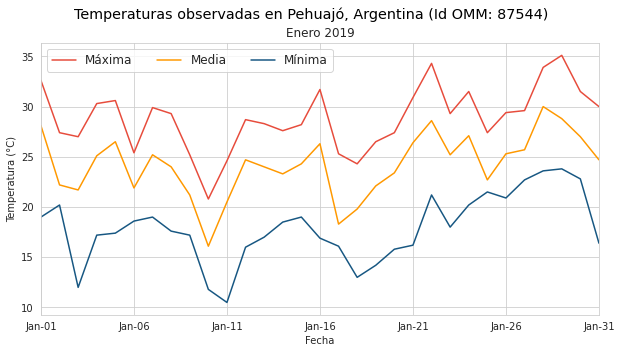

In [17]:
# Serie temporal de temperaturas
serie_temperaturas = (registros_largo
    .assign(fecha=lambda x: pd.to_datetime(x.fecha))
    .query("variable_id in ['tmax','tmin','tmed']"))
    
plt.figure(figsize=(10, 5))
plt.suptitle('Temperaturas observadas en Pehuajó, Argentina (Id OMM: 87544)', fontsize='x-large')

seaborn.set_style('whitegrid')
seaborn.set_palette(["#e74c3c","#ff9900","#175782"])
ax = seaborn.lineplot(x=serie_temperaturas.fecha, y=serie_temperaturas.valor,
                      hue=serie_temperaturas.variable_id.rename("Temperatura")
                              .map({"tmax": "Máxima", "tmed": "Media", "tmin": "Mínima"}),
                      hue_order=["Máxima", "Media", "Mínima"], palette=seaborn.color_palette())
                              
ax.xaxis.set_major_locator(mdates.DayLocator(interval=5))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%d'))
ax.set_xbound(lower=datetime.date(2019,1,1), upper=datetime.date(2019,1,31))

ax.set_title('Enero 2019', fontsize='large')
ax.set_xlabel('Fecha')
ax.set_ylabel('Temperatura (°C)')
ax.legend(fontsize='large', ncol=4)

plt.show()


### 4.2.2. Búsqueda de datos para *una* de las variables observadas en una estación meteorológica

*Ruta*: /registros_diarios/{omm_id:int}/{variable_id:string}/{fecha_desde}/{fecha_hasta}

*Método*: GET

*Parámetros*: 

  * omm_id: Id OMM de la estación meteorológica;
  * variable_id: variable cuyos datos se van a buscar;
  * fecha_desde: Fecha a partir de la cual se buscan datos;
  * fecha_hasta: Fecha hasta la cual se buscan datos. Debe ser posterior a fecha_desde y la cantidad de días incluidos entre ambas fechas no debe superar los 3650 días (o sea, solo se pueden buscar aproximadamente 10 años por llamada al servicio).
  
*Respuesta*: 
[
  {
    omm_id: integer
    fecha: date,
    variable_id: string,
    estado: string,
    valor: float
  }
]

*Ejemplo*:

In [18]:
# Búsqueda de datos para una de las variables observadas por una estación meteorológica, en lenguaje Python.
fecha_desde           = dateutil.parser.parse("2014-01-01").isoformat()
fecha_hasta           = dateutil.parser.parse("2018-01-31").isoformat()
url_registros_diarios = f"{base_url}/registros_diarios/87544/tmax/{fecha_desde}/{fecha_hasta}"
registros_largo       = consumir_servicio_JSON(url=url_registros_diarios, 
                                               usuario=usuario_default, clave=clave_default)

# Tabla de datos de fechas y valores de tmax
print(registros_largo.loc[0:5, ("fecha", "valor")].to_markdown(tablefmt="github", showindex=False))


| fecha      |   valor |
|------------|---------|
| 2014-01-01 |    31   |
| 2014-01-02 |    27.1 |
| 2014-01-03 |    25.3 |
| 2014-01-04 |    35.1 |
| 2014-01-05 |    36.6 |
| 2014-01-06 |    39   |


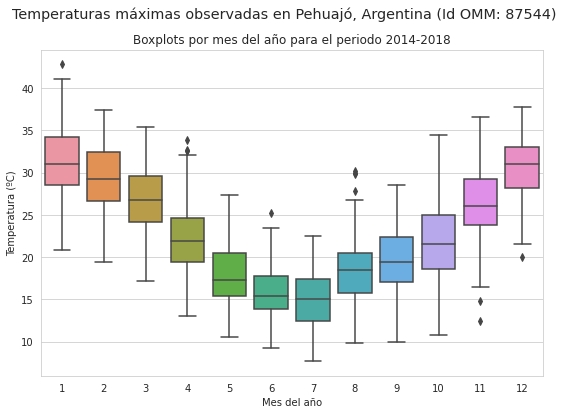

In [19]:
# Boxplot de temperaturas por mes del año
boxplot_temperaturas = (registros_largo 
    .assign(fecha=lambda x: pd.to_datetime(x.fecha)) 
    .assign(mes=lambda x: x.fecha.dt.month))

plt.figure(figsize=(9, 6))
plt.suptitle('Temperaturas máximas observadas en Pehuajó, Argentina (Id OMM: 87544)', fontsize='x-large')

seaborn.set_style('whitegrid')
ax = seaborn.boxplot(x='mes', y='valor', data=boxplot_temperaturas) 

ax.set_title('Boxplots por mes del año para el periodo 2014-2018', fontsize='large')
ax.set_xlabel('Mes del año')
ax.set_ylabel('Temperatura (ºC)')

plt.show()


## 4.3. Estadísticas y normales climáticas

### 4.3.1. Estadísticas climáticas

Este servicio devuelve —por cada llamada— un estadístico descriptivo para tres variables climáticas (precipitación y temperaturas máxima y mínima) observadas en una estación meteorológica. Los estadísticos descriptivos disponibles se muestran en la tabla siguiente; todos los estadísticos listados en la tabla se calculan para todas las variables (a excepción de *ocurrencia* que se calcula solamente para precipitación). Por lo tanto, si se desean estadísticos diferentes para algunas variables, por ejemplo totales de precipitación y promedios de temperatura, se deberá ejecutar el servicio dos veces (una vez por cada estadístico deseado).

Los estadísticos están calculados para ventanas de tiempo móviles de diferentes anchos (de 1 a 24 meses). Estas ventanas de tiempo se desplazan cada una péntada. Una péntada es un período de aproximadamente 5 días. Hay 6 péntadas por mes, las cuales comienzan en los días 1, 6, 11, 16, 21 y 26 de cada mes. Las primeras 5 péntadas del mes incluyen siempre 5 días, mientras que la última péntada del mes puede incluir entre 3 y 6 días dependiendo de la cantidad de días del mes. De acuerdo a esta definición, una péntada siempre comienza y termina dentro del mismo mes calendario.

*Ruta*: /estadisticas_moviles/{omm_id:int}/{estadistico:string}/{ancho_ventana:int}/{fecha_desde}/{fecha_hasta}

*Método*: GET

*Parámetros*: 

  * omm_id: Id OMM de la estación meteorológica;
  * estadistico: ver campo *id* en la tabla siguiente
  
  id                 | estadístico
  ------------------ | ----------------------------------------------------------------------
  Suma               | Sumatoria de los valores
  Media              | Media muestral
  Mediana            | Mediana muestral
  DesviacionEstandar | Desviación estándar muestral
  MAD                | Mediana de desviaciones absolutas
  NFaltantes         | Cantidad de valores faltantes en la muestra
  NDisponibles       | Cantidad de valores no faltantes en la muestra
  Ocurrencia         | Cantidad de días con precipitación mayor a 0.1 mm (sólo aplicable a precipitación)
  
  * ancho_ventana: ancho de la ventana de agregación en péntadas = { 6, 12, 18, 36, 54, 72, 108, 144, 216, 288 }
  * fecha_desde: Fecha a partir de la cual se buscan datos;
  * fecha_hasta: Fecha hasta la cual se buscan datos. Debe ser posterior a fecha_desde y la cantidad de días incluidos entre ambas fechas no debe superar los 3650 días.
  
*Respuesta*: 
[
  {
    omm_id: integer
    fecha_desde: date,
    fecha_hasta: date,
    variable_id: string { tmax, tmin, prcp }
    valor: float
  }
]

En el ejemplo que se muestra a continuación, se solicitan las medias de las tres variables descriptas arriba para la estación Pehuajó (Id OMM 87544), agrupadas en períodos móviles de 6 péntadas (aproximadamente un mes) de ancho especificado a través del parámetro *ancho_ventana*. Dado que los datos solicitados corresponden al período 2018-01-01 / 2018-03-31, existen 13 ventanas móviles de 6 péntadas de ancho *completamente* comprendidas dentro de este período: la primera ventana comprende el período 2018-01-01 / 2018-01-31, la segunda ventana incluye el período 2018-01-06 / 2018-02-05, y la última ventana comprende el período 2018-03-01 / 2018-03-31. 

Como se indicó previamente, las ventanas que devuelve este servicio son aquellas cuyas péntadas correspondientes se encuentran *completamente* comprendidas dentro del intervalo de fechas especificado. Por tal motivo, si el argumento fecha_desde no coincide con el inicio de una péntada (ej: 2018-01-03), entonces la primera ventana devuelta será la que comience en la péntada siguiente a la fecha_desde. Análogamente, si el argumento fecha_hasta no coincide con el fin de una péntada (ej: 2018-03-28), la última ventana devuelta será la que finalice en la péntada previa a fecha_hasta. En resumen, si el intervalo especificado fuera 2018-01-03 / 2018-03-28, el servicio devolvería los estadísticos para las 11 ventanas móviles de 6 péntadas de ancho completamente comprendidas dentro del intervalo especificado. 

In [20]:
# Búsqueda de estadísticas climáticas para precipitación y temperaturas máxima y mínima.
fecha_desde        = dateutil.parser.parse("2018-01-01").isoformat()
fecha_hasta        = dateutil.parser.parse("2018-03-31").isoformat()
url_estadisticas   = f"{base_url}/estadisticas_moviles/87544/Media/6/{fecha_desde}/{fecha_hasta}"
estadisticas_largo = consumir_servicio_JSON(url=url_estadisticas,
                                            usuario=usuario_default, clave=clave_default)
estadisticas_ancho = (estadisticas_largo
    .pivot_table(index=['omm_id', 'fecha_desde', 'fecha_hasta'], columns='variable_id', values='valor')
    .reset_index().rename_axis(None, axis=1))

# Tabla de datos de fechas y valores de precipitación y temperaturas máxima y mínima
print(estadisticas_ancho.head(6).to_markdown(tablefmt="github", showindex=False))


|   omm_id | fecha_desde   | fecha_hasta   |   prcp |    tmax |    tmin |
|----------|---------------|---------------|--------|---------|---------|
|    87544 | 2018-01-01    | 2018-01-31    | 2.6903 | 31.3968 | 16.6581 |
|    87544 | 2018-01-06    | 2018-02-05    | 2.2065 | 31.9129 | 17.0161 |
|    87544 | 2018-01-11    | 2018-02-10    | 2.4968 | 31.729  | 17.3065 |
|    87544 | 2018-01-16    | 2018-02-15    | 2.2387 | 31.3968 | 16.1097 |
|    87544 | 2018-01-21    | 2018-02-20    | 4.3226 | 31.5194 | 16.1161 |
|    87544 | 2018-01-26    | 2018-02-25    | 4.3226 | 30.9968 | 15.5452 |


### 4.3.2. Normales climáticas mensuales

Este servicio devuelve las normales climáticas para una estación meteorológica, cada mes del año y tres variables (precipitación y temperaturas máxima y mínima). Para el caso de la precipitación, el servicio devuelve el promedio de precipitación acumulada mensual para cada mes calendario considerando todos los años dentro del período de referencia especificado. De la misma manera, para el caso de las temperaturas máxima y mínima, se devuelve el promedio de los valores medios para cada mes calendario considerando todos los años dentro del período de referencia especificado.

Consideremos a modo de ejemplo que el usuario desea solicitar las normales climáticas para una estación cualquiera considerando el período de referencia 1981-2010. La precipitación normal devuelta para el mes de enero, será el promedio de todas las precipitaciones acumuladas para los 30 meses de enero comprendidos entre 1981 y 2010. La temperatura normal (mínima o máxima) devuelta para el mes de enero, será el promedio de todas las temperaturas medias mensuales (mínima o máxima) para los 30 meses de enero comprendidos entre 1981 y 2010.

*Ruta*: /normales_climatologicas_mensuales/{omm_id:int}/{referencia_ano_desde:int}/{referencia_ano_hasta:int}

*Método*: GET

*Parámetros*: 

  * omm_id: Id OMM de la estación meteorológica;
  * referencia_ano_desde: año de inicio del período de referencia; y
  * referencia_ano_hasta: año de fin del período de referencia.
  
*Respuesta*: 
[
  {
    omm_id: integer,
    variable_id: string { tmax, tmin, prcp },
    mes: integer (1, 2, ..., 12),
    normal: float,
    proporcion_datos_disponibles: float
  }
]

*Ejemplo*:

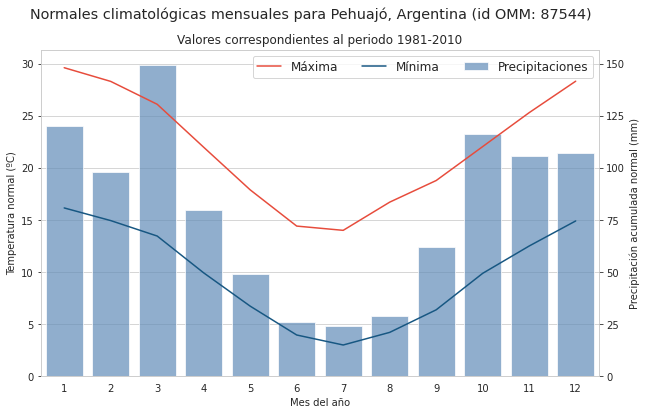

In [21]:
# Búsqueda de normales climatológicas mensuales para Pehuajó con período de referencia 1981-2010.
omm_id    = 87544
ano_desde = 1981
ano_hasta = 2010
url_normales_climatologicas = f"{base_url}/normales_climatologicas_mensuales/{omm_id}/{ano_desde}/{ano_hasta}"
normales_climatologicas_mensuales = consumir_servicio_JSON(url=url_normales_climatologicas,
                                                           usuario=usuario_default, clave=clave_default)
                                                         
# Gráfico de normales climatológicas de temperatura mínima (tmin) y máxima (tmax) y precipitaciones (prcp)
normales_temperaturas = normales_climatologicas_mensuales.query("variable_id in ['tmax','tmin']")
normales_precipitaciones = normales_climatologicas_mensuales.query("variable_id == 'prcp'")  

plt.figure(figsize=(10, 6))
plt.suptitle('Normales climatológicas mensuales para Pehuajó, Argentina (id OMM: 87544)', fontsize='x-large')

seaborn.set_style('whitegrid')

# Gráfico de temperatura
seaborn.set_palette(["#e74c3c","#175782"])
ax_temp = seaborn.lineplot(x=normales_temperaturas.mes.subtract(1), y=normales_temperaturas.normal,
                           hue=normales_temperaturas.variable_id.rename('Temperatura')
                                   .map({'tmax': 'Máxima', 'tmin': 'Mínima'}),
                           hue_order=["Máxima", "Mínima"], palette=seaborn.color_palette())
ax_temp.legend(fontsize='large', ncol=4)

# Gráfico de precipitación
seaborn.set_palette(["#538cc6"])
ax_prcp = seaborn.barplot(x=normales_precipitaciones.mes, y=normales_precipitaciones.normal.divide(5),
                          hue=normales_precipitaciones.variable_id.map({'prcp': 'Precipitaciones'}), 
                          alpha=.7, palette=seaborn.color_palette())
ax_prcp.legend(fontsize='large', ncol=4)

# Labels
ax_plt = plt.gca()
ax_plt.set_title('Valores correspondientes al periodo 1981-2010', fontsize='large')
ax_plt.set_ylabel('Temperatura normal (ºC)')
ax_plt.set_xlabel('Mes del año')

# Eje derecho
ax_aux = ax_plt.twinx()  
_ = ax_aux.set(ylim=ax_temp.get_ylim(), yticklabels=ax_temp.get_yticks().astype(int) * 5)
_ = ax_aux.set_ylabel('Precipitación acumulada normal (mm)')
ax_aux.grid(False)

plt.show()


### 4.3.3. Estadísticas mensuales

Este servicio devuelve —por cada llamada— el agregado mensual de un estadístico descriptivo para una de estas tres variables climáticas (precipitación y temperaturas máxima y mínima) observadas en una estación meteorológica. Los estadísticos descriptivos disponibles se muestran en la tabla siguiente; todos los estadísticos listados en la tabla se calculan y agregan para todas las variables (a excepción de *ocurrencia* que se calcula solamente para precipitación). Por lo tanto, si se desean estadísticos diferentes para una misma variable, por ejemplo totales de precipitación y desviación estándar muestral de la precipitación, se deberá ejecutar el servicio dos veces (una vez por cada estadístico deseado).

Los estadísticos están calculados para ventanas de tiempo móviles de diferentes anchos (de 1 a 24 meses). Estas ventanas de tiempo se desplazan cada una péntada. Una péntada es un período de aproximadamente 5 días. Hay 6 péntadas por mes, las cuales comienzan en los días 1, 6, 11, 16, 21 y 26 de cada mes. Las primeras 5 péntadas del mes incluyen siempre 5 días, mientras que la última péntada del mes puede incluir entre 3 y 6 días dependiendo de la cantidad de días del mes. De acuerdo a esta definición, una péntada siempre comienza y termina dentro del mismo mes calendario. Por lo tanto, es posible agregar los datos por mes, para esto es necesario considerar un ancho de ventana de agregación de 6 péntadas, iniciando la agregación en la primer péntada del mes. Es justamente esto lo que hace este servicio, y además, este comportamiento no puede ser modificado.

*Ruta*: /estadisticas_mensuales/{omm_id:int}/{variable_id:string}/{estadistico:string}/{ano_desde:int}/{ano_hasta:int}

*Método*: GET

*Parámetros*: 

  * omm_id: Id OMM de la estación meteorológica;
  * variable_id: variable cuyos datos se van a buscar;
  * estadistico: ver campo *id* en la tabla siguiente
  
  id                 | estadístico
  ------------------ | ----------------------------------------------------------------------
  Suma               | Sumatoria de los valores
  Media              | Media muestral
  Mediana            | Mediana muestral
  DesviacionEstandar | Desviación estándar muestral
  MAD                | Mediana de desviaciones absolutas
  NFaltantes         | Cantidad de valores faltantes en la muestra
  NDisponibles       | Cantidad de valores no faltantes en la muestra
  Ocurrencia         | Cantidad de días con precipitación mayor a 0.1 mm (sólo aplicable a precipitación)
  
  * anho_desde: Año a partir de la cual se buscan datos;
  * anho_hasta: Año hasta la cual se buscan datos.
  
*Respuesta*: 
[
  {
    omm_id: integer
    anho: integer
    mes: integer (1, 2, ..., 12)
    variable: string { tmax, tmin, prcp }
    estadistico: string { Suma. Media, Mediana, DesviacionEstandar, MAD, NFaltantes, NDisponibles, Ocurrencia }
    valor: float
  }
]

En el ejemplo que se muestra a continuación, se solicitan las medias de las tres variables descriptas arriba para la estación Pehuajó (Id OMM 87544), agrupadas en períodos móviles de 6 péntadas, iniciando siempre en la primer péntada del mes (esto es siempre así al utilizar este servicio, es decir, no se pueden modificar ni el anho de ventana de la agregación, no la péntada de inicio). 


In [22]:
# Búsqueda de totales mensuales de precipitación.
url_estadisticas   = f"{base_url}/estadisticas_mensuales/87544/prcp/Suma/2000/2001"
estadisticas_largo = consumir_servicio_JSON(url=url_estadisticas,
                                            usuario=usuario_default, clave=clave_default)
estadisticas_ancho = (estadisticas_largo
    .pivot_table(index=['omm_id', 'anho', 'mes', 'estadistico'], columns='variable', values='valor')
    .reset_index().rename_axis(None, axis=1))

# Tabla de datos de totales mensuales
print(estadisticas_ancho.to_markdown(tablefmt="github", showindex=False))

|   omm_id |   anho |   mes | estadistico   |   prcp |
|----------|--------|-------|---------------|--------|
|    87544 |   2000 |     1 | Suma          |  217.7 |
|    87544 |   2000 |     2 | Suma          |  218.3 |
|    87544 |   2000 |     3 | Suma          |   99.5 |
|    87544 |   2000 |     4 | Suma          |   47.5 |
|    87544 |   2000 |     5 | Suma          |  180   |
|    87544 |   2000 |     6 | Suma          |   26   |
|    87544 |   2000 |     7 | Suma          |    6.3 |
|    87544 |   2000 |     8 | Suma          |   19.1 |
|    87544 |   2000 |     9 | Suma          |    9.4 |
|    87544 |   2000 |    10 | Suma          |  282.7 |
|    87544 |   2000 |    11 | Suma          |   93.4 |
|    87544 |   2000 |    12 | Suma          |   46.8 |
|    87544 |   2001 |     1 | Suma          |  117   |
|    87544 |   2001 |     2 | Suma          |  151.5 |
|    87544 |   2001 |     3 | Suma          |  207.8 |
|    87544 |   2001 |     4 | Suma          |  142.6 |
|    87544

## 4.4. Índices de sequía

El CRC-SAS ha implementado el cálculo de cuatro índices o métricas de sequía basados en datos de estaciones meteorológicas convencionales: 

  * Índice de Precipitación Estandarizado (SPI);
  * Índice de Precipitación - Evapotranspiración Estandarizado (SPEI);
  * Deciles de Precipitación; y
  * Porcentaje de Precipitación Normal (PPN).

En todos los casos, los valores de los índices se calculan a partir de datos de precipitación acumulada. Solamente en el caso del SPEI se utilizan además datos de evapotranspiración potencial estimada utilizando la fórmula de Hargreaves-Samani [9]. La duración del período de acumulación es lo que se define como escala de un índice. Resulta entonces que el SPI-2 denota el valor del índice SPI para una escala de 2 meses. 

Anteriormente el CRC-SAS calculaba los valores de los índices a mes vencido. Es decir, que el valor de SPI-2 para Mayo de 2017 (que comprende precipitaciones de Abril y Mayo de 2017) se hubiera calculado recién los primeros días de Junio de 2017. Actualmente, el CRC-SAS tiene un nuevo mecanismo que produce 6 valores de índices por mes en vez de solamente uno. Esto se debe a que la unidad básica de cálculo es la péntada (ver sección 4.3.1). Las péntadas están definidas con el mismo criterio que en el producto CHIRPS [10]. 

De este modo, la actualización de índices de sequía ocurre a péntada vencida en vez de a mes vencido, logrando una mayor frecuencia en la disponibilidad de la información. A efectos de ilustrar tanto el cálculo mensual como el cálculo por péntadas, se presenta la siguiente figura:


![Ilustración del cálculo de índices de sequía según metodología antigua (filas a y b) y actual (filas c, d, y e)](img/Indices-Sequia-Pentadas.png)


A continuación se describirán cuatro servicios que proveerán los valores de los índices de sequía y otra información asociada a los mismos: a) configuraciones de índices de sequía; b) datos de índices de sequía; c) parámetros de ajuste de distribuciones; y d) resultados de pruebas de bondad de ajuste.

### 4.4.1. Configuraciones para el cálculo de índices de sequía

Un índice de sequía asociado a una escala temporal (por ejemplo, el SPI-3) se puede calcular de distintas maneras. En particular, necesitamos conocer la siguiente información:

  * distribución ajustada a los datos de entrada;
  * método de estimación de los parámetros de la distribución ajustada a partir de datos de entrada; y
  * período de referencia (ej.: 1971-2010) que se utilizarán para ajustar la distribución.
  
El valor de un índice indica dónde se ubica ese valor en relación a la distribución ajustada a los valores de entrada. Con los datos que corresponden a un período de referencia se ajusta una distribución (paramétrica o no paramétrica). Para poder realizar el cálculo del índice, debemos primero caracterizar la distribución de los datos de entrada para el período de referencia. Para ello se busca una distribución estadística cuya función de densidad de probabilidades represente adecuadamente la distribución histórica del conjunto de datos para el período de referencia. Por ejemplo, para el caso del SPI (cuyo dato de entrada es una precipitación acumulada), la distribución gamma es una buena aproximación para la distribución de la precipitación tomada como variable aleatoria.

Una vez que se ha definido la función de densidad de probabilidades para los datos de entrada en el período de referencia, es necesario seleccionar un método de ajuste para estimar los parámetros que describen dicha función. Por ejemplo, en el caso de una distribución gamma (para el caso de un índice SPI), es necesario estimar los dos parámetros que definen unívocamente esa distribución: forma (shape) y escala (scale). A modo de ejemplo, un método de ajuste que podría utilizarse para ajustar dichos parámetros podría ser el método de máxima verosimilitud. Luego, una vez seleccionadas la función de densidad y el método de ajuste de parámetros, se estiman los valores de los parámetros para los datos de entrada para el período de referencia. A partir de este momento, se tiene toda la información necesaria para calcular el valor del índice de sequía. Para mayor detalle sobre el cálculo de los índices de sequía, consultar [11].

El CRC-SAS provee datos para distintas combinaciones de índices y escalas. Para cada una de estas combinaciones, se pueden realizar distintos tipos de ajuste tal como se explicó anteriormente. Cada combinación única de índice, escala temporal (expresada en meses), función de distribución, método de ajuste y período de referencia se denomina *configuración* de un índice de sequía. A su vez, cada configuración tiene asignado un identificador único que se usará en los servicios subsiguientes para extraer distintas cantidades (valores de índice, valores de parámetros ajustados y resultados de tests de bondad de ajuste) para una combinación o configuración dada. El servicio que se describe a continuación permite listar todas las configuraciones para las cuales el CRC-SAS calcula valores de índices de sequía.

*Ruta*: /indices_sequia_configuraciones

*Método*: GET

*Parámetros*: ninguno

*Respuesta*: 
[
  {
    id: integer
    indice: string,
    escala (expresada en meses): integer,
    distribucion: string,
    metodo_ajuste: integer,
    referencia_comienzo: date,
    referencia_fin: date
  }
]

*Ejemplo*:

In [23]:
# Búsqueda de configuraciones de cálculo de índices de sequía.
configuraciones = consumir_servicio_JSON(url= base_url + "/indices_sequia_configuraciones",
                                         usuario=usuario_default, clave=clave_default)

# Vista de las primeras 6 configuraciones en una tabla
print(configuraciones.head(6).to_markdown(tablefmt="github", showindex=False))


|   id | indice   |   escala | distribucion   | metodo_ajuste    | referencia_comienzo   | referencia_fin   |   procesable |
|------|----------|----------|----------------|------------------|-----------------------|------------------|--------------|
|    1 | SPI      |        1 | Gamma          | NoParametrico    | 1971-01-01            | 2010-12-31       |            1 |
|   41 | SPI      |        1 | Gamma          | ML-SinRemuestreo | 1971-01-01            | 2010-12-31       |            1 |
|    2 | SPI      |        2 | Gamma          | NoParametrico    | 1971-01-01            | 2010-12-31       |            1 |
|   42 | SPI      |        2 | Gamma          | ML-SinRemuestreo | 1971-01-01            | 2010-12-31       |            1 |
|    3 | SPI      |        3 | Gamma          | NoParametrico    | 1971-01-01            | 2010-12-31       |            1 |
|   43 | SPI      |        3 | Gamma          | ML-SinRemuestreo | 1971-01-01            | 2010-12-31       |            1 |


### 4.4.2. Valores de índices de sequía

Esta sección describe el servicio que permite consultar los valores de índices de sequía. Para obtener estos valores, es necesario indicar la estación meteorológica para la cual se desea consultar los datos. El servicio permite consultar los valores de índices para una estación por vez. La estación meteorológica se define a través de su Id OMM (por ejemplo, la estación Pehuajó del Servicio Meteorológico Nacional de Argentina tiene el Id OMM 87544). Además de esta información se necesita especificar la configuración del índice deseado (ver la sección anterior).
  
Finalmente, cabe destacar que este servicio, además de devolver el valor del índice especificado, provee también el valor del dato de entrada (por ejemplo la precipitación acumulada para la escala temporal del SPI; en el caso del SPEI, corresponde a la precipitación acumulada para la escala temporal menos la evapotranspiración potencial para el mismo período) y el percentil asociado al valor del índice en relación a la distribución estadística ajustada para el período de referencia.

*Ruta*: /indices_sequia_valores/{indice_configuracion_id:int}/{omm_id:int}/{fecha_desde}/{fecha_hasta}

*Método*: GET

*Parámetros*: 

  * indice_configuracion_id: Id de la configuración asociada al índice y escala según lo descripto en la sección de *configuraciones*;
  * omm_id: Id OMM de la estación meteorológica;
  * fecha_desde: Fecha a partir de la cual se buscan los valores de los índices (debe tomarse en cuenta que la fecha de un índice corresponde a la fecha de finalización del período de agregación);
  * fecha_hasta: Fecha hasta la cual se buscan los valores de los índices (debe tomarse en cuenta que la fecha de un índice corresponde a la fecha de finalización del período de agregación).
  
*Respuesta*: 
[
  {
    indice_configuracion_id: integer
    omm_id: integer,
    pentada_fin: integer,
    ano: integer,
    metodo_imputacion_id: integer,
    valor_dato: float,
    valor_indice: float,
    percentil_dato: float
  }
]

*Ejemplo*:

In [24]:
# Búsqueda valores de SPI-3 para Pehuajó, Argentina, con ajuste por máxima verosimilitud sin remuestreo (configuración 43).
omm_id                  = 87544
indice_configuracion_id = 43
fecha_desde             = dateutil.parser.parse("2018-01-01").isoformat()
fecha_hasta             = dateutil.parser.parse("2018-03-31").isoformat()
url_valores_indice = f"{base_url}/indices_sequia_valores/{indice_configuracion_id}/{omm_id}/{fecha_desde}/{fecha_hasta}"
spi_3_enero_2018   = consumir_servicio_JSON(url=url_valores_indice,
                                            usuario=usuario_default, clave=clave_default)

# Vista de los datos de SPI-3 para Enero de 2018.
print(spi_3_enero_2018.head(6).to_markdown(tablefmt="github", showindex=False))


|   indice_configuracion_id |   omm_id |   pentada_fin |   ano |   metodo_imputacion_id |   valor_dato |   valor_indice |   percentil_dato |
|---------------------------|----------|---------------|-------|------------------------|--------------|----------------|------------------|
|                        43 |    87544 |             1 |  2018 |                      0 |        180.6 |        -1.4945 |           6.7527 |
|                        43 |    87544 |             2 |  2018 |                      0 |        176.5 |        -1.7916 |           3.6602 |
|                        43 |    87544 |             3 |  2018 |                      0 |        184.4 |        -2.0568 |           1.9854 |
|                        43 |    87544 |             4 |  2018 |                      0 |        167.8 |        -2.0481 |           2.0274 |
|                        43 |    87544 |             5 |  2018 |                      0 |        167.8 |        -1.9979 |           2.2865 |
|            


Si lo que se desea es solamente buscar el último valor disponible de un índice de sequía (definido a partir de una configuración) para una estación meteorológica determinada, se puede utilizar el servicio anteriormente descripto sin especificar fechas de inicio o fin.

*Ruta*: /indices_sequia_valores/{indice_configuracion_id:int}/{omm_id:int}

*Método*: GET

*Parámetros*: 

  * indice_configuracion_id: Id de la configuración asociada al índice y escala según lo descripto en la sección de *configuraciones*;
  * omm_id: Id OMM de la estación meteorológica;
  
*Respuesta*: 
[
  {
    indice_configuracion_id: integer
    omm_id: integer,
    pentada_fin: integer,
    ano: integer,
    metodo_imputacion_id: integer,
    valor_dato: float,
    valor_indice: float,
    percentil_dato: float
  }
]

*Ejemplo*:

In [25]:
# Búsqueda valores de SPI-3 para Pehuajó, Argentina, con ajuste por máxima verosimilitud sin remuestreo (configuración 43).
# Buscar solamente el valor más reciente.
omm_id                  = 87544
indice_configuracion_id = 43
url_valores_indice      = f"{base_url}/indices_sequia_valores/{indice_configuracion_id}/{omm_id}"
spi_3_ultimo            = consumir_servicio_JSON(url=url_valores_indice,
                                                 usuario=usuario_default, clave=clave_default)

# Mostrar valor de SPI-3 más reciente
print(spi_3_ultimo.to_markdown(tablefmt="github", showindex=False))


|   indice_configuracion_id |   omm_id |   pentada_fin |   ano |   metodo_imputacion_id |   valor_dato |   valor_indice |   percentil_dato |
|---------------------------|----------|---------------|-------|------------------------|--------------|----------------|------------------|
|                        43 |    87544 |            67 |  2021 |                      0 |        323.7 |          0.477 |          68.3318 |


### 4.4.3. Parámetros y otros valores resultantes del ajuste de distribuciones

Esta sección describe el servicio que permite consultar los parámetros vinculados al ajuste de distribuciones estadísticas para cada configuración descripta en la sección *configuraciones* (a excepción de las configuraciones correspondientes a ajustes no paramétricos). Los valores que devuelve este servicio dependen de la configuración y la estación seleccionadas. Dadas una configuración y estación, se devuelven todos los parámetros de ajuste para las 72 péntadas para las cuales se calcula el índice. 

Además, el servicio devuelve otros valores asociados al cálculo de índices de sequía. Por ejemplo, las probabilidades asociadas con la corrección propuesta por Stagge et. [12] por la ocurrencia de días sin lluvia dentro del período de referencia (ver ecuaciones 2 y 3 del artículo mencionado).

En algunos casos, valores faltantes de los índices de sequía se pueden completar mediante un proceso de imputación. El método de imputación utilizado se lista en la columna *metodo_imputacion_id*. Si el código de esta columna es igual a cero, es porque no se han imputado posibles datos faltantes.

*Ruta*: /indices_sequia_parametros_ajuste/{indice_configuracion_id:int}/{omm_id:int}

*Método*: GET

*Parámetros*: 

  * indice_configuracion_id: Id de la configuración asociada al índice y escala según lo descripto en la sección de *configuraciones*;
  * omm_id: Id OMM de la estación meteorológica;
  
*Respuesta*: 
[
  {
    indice_configuracion_id: integer
    omm_id: integer,
    pentada_fin: integer,
    parametro: string,
    metodo_imputacion_id: integer,
    valor: float
  }
]

*Ejemplo*:

In [26]:
# Búsqueda parámetros de ajuste por máxima verosimilitud sin remuestreo para SPI-3 en Pehuajó, Argentina.
omm_id                  = 87544
indice_configuracion_id = 43
url_parametros_ajuste   = f"{base_url}/indices_sequia_parametros_ajuste/{indice_configuracion_id}/{omm_id}"
parametros_ajuste       = consumir_servicio_JSON(url=url_parametros_ajuste,
                                                 usuario=usuario_default, clave=clave_default)
                                          
# Selección de parámetros correspondientes a las péntadas 1 y 2.
parametros_pentadas_1_y_2 = parametros_ajuste.query("pentada_fin in [1, 2]")

# Vista de los datos previamente filtrados en una tabla
print(parametros_pentadas_1_y_2.head(6).to_markdown(tablefmt="github", showindex=False))


|   indice_configuracion_id |   omm_id |   pentada_fin | parametro    |   metodo_imputacion_id |   valor |
|---------------------------|----------|---------------|--------------|------------------------|---------|
|                        43 |    87544 |             1 | alpha        |                      0 |  9.5761 |
|                        43 |    87544 |             1 | beta         |                      0 | 33.2946 |
|                        43 |    87544 |             1 | prob.0       |                      0 |  0      |
|                        43 |    87544 |             1 | prob.media.0 |                      0 |  0      |
|                        43 |    87544 |             2 | alpha        |                      0 | 11.7689 |
|                        43 |    87544 |             2 | beta         |                      0 | 27.5362 |


### 4.4.4. Resultados de pruebas de bondad de ajuste

Este servicio permite consultar los resultados de las pruebas de bondad de ajuste para la distribución especificada en cada configuración descripta en la sección *configuraciones* (a excepción de las configuraciones correspondientes a ajustes no paramétricos). Los valores que devuelve este servicio dependen de la configuración y la estación meteorológica seleccionadas. Se devuelven todos los resultados de las pruebas de bondad de ajuste para las 72 péntadas para las cuales se calcula el índice especificado.

Los tests de bondad de ajuste utilizados son a) Kolmogorov-Smirnov (KS) [13], b) Anderson-Darling (AD) [14] y c) Cramèr-von Mises (CMV) [15]. Para cada uno de estos tests, se devuelve el valor del estadístico correspondiente (parámetro *statistic*) y el p-valor (parámetro *p.value*) asociado.

*Ruta*: /indices_sequia_bondad_ajuste/{indice_configuracion_id:int}/{omm_id:int}

*Método*: GET

*Parámetros*: 

  * indice_configuracion_id: Id de la configuración asociada al índice y escala según lo descripto en la sección de *configuraciones*;
  * omm_id: Id OMM de la estación meteorológica;
  
*Respuesta*: 
[
  {
    indice_configuracion_id: integer
    omm_id: integer,
    pentada_fin: integer,
    test: string,
    metodo_imputacion_id: integer,
    valor: float
  }
]

*Ejemplo*:

In [27]:
# Búsqueda resultados de bondad de ajuste por máxima verosimilitud sin remuestreo para SPI-3 en Pehuajó, Argentina.
omm_id                  = 87544
indice_configuracion_id = 43
url_bondad_ajuste       = f"{base_url}/indices_sequia_bondad_ajuste/{indice_configuracion_id}/{omm_id}"
bondad_ajuste           = consumir_servicio_JSON(url=url_bondad_ajuste,
                                           usuario=usuario_default, clave=clave_default)
                                          
# Selección de resultados de bondad de ajuste para tests KS (Kolmogorov-Smirnoff), AD (Anderson-Darling) y CVM (Cràmer-von Mises) correspondientes a la péntada 1.
bondad_pentadas_1 = bondad_ajuste.query("pentada_fin == 1 and test in ['KS','AD','CVM']")

# Vista de los datos previamente filtrados en una tabla
print(bondad_pentadas_1.head(6).to_markdown(tablefmt="github", showindex=False))


|   indice_configuracion_id |   omm_id |   pentada_fin | test   | parametro   |   metodo_imputacion_id |   valor |
|---------------------------|----------|---------------|--------|-------------|------------------------|---------|
|                        43 |    87544 |             1 | KS     | p.value     |                      0 |  0.7194 |
|                        43 |    87544 |             1 | KS     | statistic   |                      0 |  0.1061 |
|                        43 |    87544 |             1 | AD     | p.value     |                      0 |  0.765  |
|                        43 |    87544 |             1 | AD     | statistic   |                      0 |  0.4813 |
|                        43 |    87544 |             1 | CVM    | p.value     |                      0 |  0.7111 |
|                        43 |    87544 |             1 | CVM    | statistic   |                      0 |  0.0772 |


## 4.5. Eventos secos y húmedos identificados mediante índices de sequía calculados a partir datos *in situ*

Los eventos secos/húmedos identificados mediante índices de sequía son períodos durante los cuales el valor de un índice de sequía especificado se ubica por encima (evento húmedo) o por debajo (evento seco) de un umbral determinado. Como se vio en la sección previa, los valores de índices de sequía se actualizan cada una péntada. Por tal motivo, los eventos asociados a índices de sequía tienen una duración mínima de una péntada. Más aún, todas las duraciones posibles están expresadas en número de péntadas. Para cada evento se calculan varias métricas:

  * intensidad: valor promedio del índice de sequía durante el evento identificado;
  * magnitud: suma de todos los valores del índice de sequía a lo largo del evento;
  * duración: cantidad de péntadas durante las cuales el valor del índice está por debajo o por arriba del umbral especificado; y
  * valores extremos: valores mínimo y máximo del índice durante el evento.
  
Este servicio permite listar todos los eventos de algún tipo (seco o húmedo) para una estación e índice de sequía determinados. A fin de generar un listado de los eventos, es necesario indicar el tipo de evento, el umbral del índice y la duración mínima del evento (para no listar eventos que sean demasiado cortos y en consecuencia, sin mucho impacto). El índice de sequía, a su vez, se especifica mediante una *configuración* de índice tal como se explicó en la Sección 4.4.1 (configuraciones de índices de sequía).

*Ruta*: /eventos/{indice_configuracion_id:int}/{omm_id:int}/{tipo_evento:string}/{umbral_indice:float}/{duracion_minima:int}

*Método*: GET

*Parámetros*: 

  * indice_configuracion_id: Id de la configuración asociada al índice y escala según lo descripto en la sección de configuraciones; 
  * omm_id: Id OMM de la estación meteorológica; 
  * tipo_evento: [ seco, humedo ] (si el tipo evento es seco, se buscan rachas de índices con valor menor o igual al umbral, mientras que si es húmedo, se buscan rachas de índices con valor mayor o igual al umbral); 
  * umbral_indice: valor del índice por debajo (eventos secos) o por encima (eventos húmedos) del cual se considera la ocurrencia de un evento; 
  * duracion_minina: cantidad mínima de péntadas que debe durar un período con valores de índices por debajo o por encima del umbral para que el suceso se considere un evento posibles impactos. 
  
*Respuesta*: 
[
  {
    omm_id: id OMM de la estación meteorológica,
    numero_evento: integer (ordinal),
    fecha_inicio: date (fecha de inicio del evento),
    fecha_fin: date (fecha de fin del evento),
    intensidad: float (valor promedio del índice durante el evento),
    magnitud: float (suma de los valores del índice durante el evento),
    duracion: integer (cantidad de péntadas que dura el evento),
    minimo: float (valor mínimo del índice durante el evento),
    maximo: float (valor máximo del índice durante el evento)
  }
]

*Ejemplo*:

In [28]:
# Búsqueda eventos para SPI-3 en Pehuajó usando ajuste por máxima verosimilitud sin remuestreo, en lenguaje Python.
# Se buscan eventos secos cuya duración mínima sea de 18 péntadas (3 meses) para los cuales el valor
# del índice sea menor o igual a -1,25.
omm_id                  = 87544
indice_configuracion_id = 43
tipo_evento             = "seco"
umbral_indice           = -1.25
duracion_minima         = 18
url_bondad_ajuste = f"{base_url}/eventos/{indice_configuracion_id}/{omm_id}/{tipo_evento}/{umbral_indice}/{duracion_minima}"
bondad_ajuste     = consumir_servicio_JSON(url=url_bondad_ajuste,
                                           usuario=usuario_default, clave=clave_default)

# Vista de los eventos que satistacen las condiciones indicadas
print(bondad_ajuste.to_markdown(tablefmt="github", showindex=False))


|   omm_id |   numero_evento | fecha_inicio   | fecha_fin   |   intensidad |   magnitud |   duracion |   minimo |   maximo |
|----------|-----------------|----------------|-------------|--------------|------------|------------|----------|----------|
|    87544 |               1 | 1961-04-06     | 1961-07-10  |      -1.9121 |   -36.3298 |         19 |  -2.4864 |  -1.2622 |
|    87544 |               2 | 1962-03-01     | 1962-05-31  |      -1.9358 |   -34.845  |         18 |  -2.7786 |  -1.255  |
|    87544 |               3 | 1995-08-11     | 1996-01-20  |      -2.0677 |   -66.1657 |         32 |  -2.7206 |  -1.5104 |
|    87544 |               4 | 2009-01-06     | 2009-06-25  |      -2.0177 |   -68.6022 |         34 |  -2.6867 |  -1.3447 |
|    87544 |               5 | 2019-09-11     | 2019-12-25  |      -2.5225 |   -52.9732 |         21 |  -3      |  -1.7494 |


## 4.6. Índices de vegetación (NDVI y EVI) a partir de datos satelitales

Este servicio permite consultar datos de índices de vegetación derivados a partir del instrumento MODIS a bordo de los satélites Aqua y Terra operados por la NASA. Los índices disponibles son el NDVI (Normalized Difference Vegetation Index) y el EVI (Enhanced Vegetation Index) [16]. Se proveen datos para cualquier aŕea incluida dentro del CRC-SAS, la cual debe especificarse en formato GeoJSON [17]. Para limitar el volumen de datos a transferir por medio del servicio, el área de la zona especificada no debe exceder los 2.000.000 km^2^.

El servicio devuelve como respuesta un stream de datos binarios correspondiente a un archivo de formato NetCDF [18]. Dicho archivo NetCDF tiene la siguiente estructura de dimensiones y variables:

  * Sistema de coordenadas: 
    * Gauss-Krüger: sistema de coordenadas planares expresadas en metros;
    * String de proyección: +proj=tmerc +lat_0=-90 +lon_0=-60 +k=1 +x_0=5500000 +y_0=0 +ellps=intl +units=m +no_defs (válido para el Sur de Sudamérica);
    * Código EPSG: 22195 (Campo Inchauspe / Argentina 5).
  * Dimensiones: 
    * easting: coordenada longitudinal expresada en metros (sistema Gauss-Krüger);
    * northing: coordenada latitudinal expresada en metros (sistema Gauss-Krüger); 
    * time: cantidad de días desde el 1 de Enero de 1970 (día 0); corresponde al inicio del período asociado a la capa de datos.
  * Variables: 
    * ndvi o evi: índice de vegetación seleccionado.
    
Con el propósito de facilitar la manipulación de los datos devueltos (que requiere conocimiento sobre archivos NetCDF), se recomienda enfáticamente utilizar la función *ConsumirServicioEspacial* provista al inicio del documento. Esta función permite invocar a este servicio y obtener directamente un objeto de tipo *numpy.ma.core.MaskedArray* [19].

*Ruta*: /indices_vegatacion/{indice}/{fecha_desde:date}/{fecha_hasta:date}

*Método*: POST

*Parámetros*: 

  * indice: índice de vegetación a consultar (ndvi o evi); 
  * fecha_desde: fecha de inicio del período a consultar (en formato ISO-8601 [20]); 
  * fecha_hasta: fecha de fin del período a consultar (en formato ISO-8601 [20]).
  
*Parámetros del cuerpo del request*:
  
  * zona.geojson: string de formato GeoJSON que representa la zona sobre la cual se efectuará la consulta.
  
*Respuesta*: Stream binario correspondiente a un archivo NetCDF (ver descripción en párrafos anteriores).

*Ejemplo*:

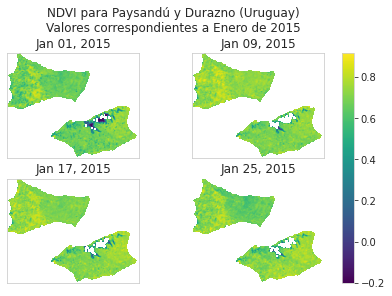

In [29]:
# Buscar todos los campos de NDVI (de satelites Terra y Aqua) dentro de Enero de 2015 
# para los departamentos de Paysandú y Durazno (Uruguay).
fecha_desde     = dateutil.parser.parse("2015-01-01").isoformat()
fecha_hasta     = dateutil.parser.parse("2015-01-31").isoformat()
url_rasters     = f"{base_url}/indices_vegetacion/ndvi/{fecha_desde}/{fecha_hasta}"
zona_geojson    = os.getcwd() + "/data/ZonasEjemplo.geojson"  # Polígonos (disjuntos) de Paysandú y Durazno
fechas, rasters = consumir_servicio_espacial(url=url_rasters, usuario=usuario_default, clave=clave_default,
                                             archivo_geojson_zona=zona_geojson, raster_var_tag='ndvi')
                                                     
# Graficar rasters de NDVI. Hay 4 rasters para enero de 2015.
figure, axes = plt.subplots(nrows=math.ceil(len(fechas)/2), ncols=1+(1%len(fechas)), 
                            constrained_layout=True)
_ = figure.suptitle('NDVI para Paysandú y Durazno (Uruguay)\n'
                    'Valores correspondientes a Enero de 2015')

for ax, fecha, raster in zip(figure.get_axes(), fechas, rasters):
    __ = ax.set_title(fecha.strftime("%b %d, %Y")), ax.set_xticks([]), ax.set_yticks([])
    im = ax.imshow(raster if len(rasters) > 1 else rasters, vmin=rasters.min(), vmax=rasters.max(), cmap='viridis')

_ = figure.colorbar(im, ax=figure.get_axes())

plt.axis('off')
plt.show()


Además de poder descargar este producto en formato *raster*, también es posible extraer series temporales de valores para un conjunto de puntos (uno o más) o polígonos (uno o más). En el caso de la extracción para un conjunto de puntos, la respuesta devuelta por el servicio es una serie temporal de valores para cada punto dentro del rango de fechas especificado. En el caso de que la extracción sea realizada para un conjunto de polígonos, la respuesta devuelta por el servicio es una serie temporal de *estadísticos* (media, mediana, desvío estándar, desviación mediana absoluta, mínimo, máximo y los percentiles correspondientes al 25% y 75%) para cada polígono dentro del rango de fechas especificado.

Los puntos o polígonos deben especificarse en formato GeoJSON [17]. Además, cada punto o polígono debe tener asociado al menos un atributo para que el servicio pueda devolver una respuesta en la cual se puedan identificar cada una de las geometrías (puntos o polígonos). Por ejemplo, en caso de que los polígonos correspondan a localidades, el archivo GeoJSON podría contener atributos indicando el código de localidad o su nombre. Para el caso de los puntos, se podría indicar un nombre asociado a cada una de las ubicaciones, un código o los atributos que el usuario desee agregar.

*Ruta*: /indices_vegatacion/serie_temporal/{indice}/{fecha_desde:date}/{fecha_hasta:date}

*Método*: POST

*Parámetros*: 

  * indice: índice de vegetación a consultar (ndvi o evi); 
  * fecha_desde: fecha de inicio del período a consultar (en formato ISO-8601 [20]); 
  * fecha_hasta: fecha de fin del período a consultar (en formato ISO-8601 [20]).
  
*Parámetros del cuerpo del request*:
  
  * zona.geojson: string de formato GeoJSON que representa los puntos o polígonos sobre los cuales se efectuará la consulta.
  
*Respuesta*:
  
El servicio devuelve una respuesta en formato JSON, la cual puede convertirse a un formato tabular. La respuesta contiene los datos provistos por el usuario para cada una de las geometrías y los siguientes campos, según el usuario haya especificado puntos o polígonos:

[
  {
    ...
    <atributos provistos por el usuario para cada punto o polígono>
    ...,
    estadístico: string (solamente para el caso de polígonos, ver detalle a continuación),
    fecha: date (fecha dentro del rango de fechas especificadas por el usuario),
    valor: float (valor asociado al punto o polígono para la fecha especificada - y al estadístico en el caso de polígonos)
  }
]

Los estadísticos devueltos para el caso de las consultas asociadas a los polígonos se codifican de la siguiente manera:

  * 0%: mínimo valor dentro del polígono
  * 25%: percentil 25 de los valores dentro del polígono
  * 50%: mediana de los valores dentro del polígono
  * 75%: percentil 75 de los valores dentro del polígono
  * 100%: máximo valor dentro del polígono
  * Media: media de los valores dentro del polígono
  * Desvio: desvío estándar de los valores dentro del polígono
  * MAD: desvío mediano absoluto de los valores dentro del polígono
  
A continuación se presentan dos ejemplos: una consulta para puntos y otra para polígonos. Para la consulta basada en puntos, cada uno de ellos tiene asociado un nombre que identifica la ubicación. Para el caso de los polígonos, cada uno de ellos tiene asociado un nombre que representa una provincia de Argentina. Se presenta primero el ejemplo para ubicaciones puntuales.

In [30]:
# Buscar NDVI para Enero de 2019 en 4 ubicaciones puntuales
fecha_desde = dateutil.parser.parse("2019-01-01").isoformat()
fecha_hasta = dateutil.parser.parse("2019-01-31").isoformat()
url_modis = f"{base_url}/indices_vegetacion/serie_temporal/ndvi/{fecha_desde}/{fecha_hasta}"
zona_geojson = os.getcwd() + "/data/PuntosEjemplo.geojson" 
datos_ndvi = consumir_servicio_espacial_serie_temporal(url=url_modis,
                                                       usuario=usuario_default, clave=clave_default,
                                                       archivo_geojson_zona=zona_geojson)
# Mostrar datos en formato tabular
print(datos_ndvi.to_markdown(tablefmt="github", showindex=False))

ConnectionError: HTTPSConnectionPool(host='api.crc-sas.org', port=443): Max retries exceeded with url: /ws-api/indices_vegetacion/serie_temporal/ndvi/2019-01-01T00:00:00/2019-01-31T00:00:00 (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x7fbb124e0910>: Failed to establish a new connection: [Errno -2] Name or service not known'))

Finalmente, se presenta un ejemplo para 3 polígonos correspondientes a zonas dentro de provincias argentinas (Buenos Aires, Santa Fe y Córdoba).

In [31]:
# Buscar NDVI para la primera quincena de Enero de 2019 en 3 provincias puntuales
fecha_desde = dateutil.parser.parse("2019-01-01").isoformat()
fecha_hasta = dateutil.parser.parse("2019-01-31").isoformat()
url_modis = f"{base_url}/indices_vegetacion/serie_temporal/ndvi/{fecha_desde}/{fecha_hasta}"
zona_geojson = os.getcwd() + "/data/PoligonosEjemplo.geojson" 
datos_ndvi = consumir_servicio_espacial_serie_temporal(url=url_modis,
                                                       usuario=usuario_default, clave=clave_default,
                                                       archivo_geojson_zona=zona_geojson)
# Mostrar datos en formato tabular
print(datos_ndvi.to_markdown(tablefmt="github", showindex=False))

| nombre       | estadistico   | fecha      |   valor |
|--------------|---------------|------------|---------|
| Buenos Aires | 0%            | 2019-01-01 |  0.0161 |
| Buenos Aires | 25%           | 2019-01-01 |  0.6263 |
| Buenos Aires | 50%           | 2019-01-01 |  0.6876 |
| Buenos Aires | 75%           | 2019-01-01 |  0.7403 |
| Buenos Aires | 100%          | 2019-01-01 |  0.9223 |
| Buenos Aires | Media         | 2019-01-01 |  0.6753 |
| Buenos Aires | Desvio        | 2019-01-01 |  0.0987 |
| Buenos Aires | MAD           | 2019-01-01 |  0.0835 |
| Buenos Aires | 0%            | 2019-01-09 | -0.1545 |
| Buenos Aires | 25%           | 2019-01-09 |  0.6678 |
| Buenos Aires | 50%           | 2019-01-09 |  0.7245 |
| Buenos Aires | 75%           | 2019-01-09 |  0.7758 |
| Buenos Aires | 100%          | 2019-01-09 |  0.9213 |
| Buenos Aires | Media         | 2019-01-09 |  0.7133 |
| Buenos Aires | Desvio        | 2019-01-09 |  0.0965 |
| Buenos Aires | MAD           | 2019-01-09 |  0

## 4.7. Precipitaciones estimadas por el producto CHIRPS

### 4.7.1. Totales de precipitación por péntada y por mes

Este servicio permite consultar valores de precipitación contenidos en el producto CHIRPS [21]. Las precipitaciones en CHIRPS son derivadas a partir de la combinación de datos satélitales e in situ. Los datos de precipitación que devuelve este servicio pueden solicitarse con un nivel de agregación temporal a escalas de péntadas o meses. Los datos de precipitación se devuelven en una grilla regular de 0,1 grado por 0,1 grado de latitud y longitud. Se proveen datos para cualquier aŕea incluida dentro del CRC-SAS, la cual debe especificarse en formato GeoJSON [17]. Para limitar el volumen de datos a transferir por medio del servicio, el área de la zona especificada no debe exceder los 2.000.000 km^2^.

El servicio devuelve como respuesta un stream de datos binarios correspondiente a un archivo de formato NetCDF [18]. Dicho archivo NetCDF tiene la siguiente estructura de dimensiones y variables:

  * Sistema de coordenadas: 
    * Latitud/Longitud: sistema de coordenadas expresadas en grados decimales;
    * String de proyección: +proj=longlat +datum=WGS84 +no_defs +ellps=WGS84 +towgs84=0,0,0;
    * Código EPSG: 4326.
  * Dimensiones: 
    * longitude: coordenada X (o longitud) expresada en grados decimales;
    * latitude: coordenada Y (o latitud) expresada en grados decimales;
    * time: cantidad de días desde el 1 de Enero de 1970 (día 0); corresponde a la fecha de inicio de la péntada o mes asociado a la capa de datos.
  * Variables: 
    * prcp: precipitación estimada por satélite acumulada por péntadas o meses (según se especifique).
    
Con el propósito de facilitar la manipulación de los datos devueltos (que requiere conocimiento sobre archivos NetCDF), se recomienda enfáticamente utilizar la función *ConsumirServicioEspacial* provista al inicio del documento. Esta función permite invocar el servicio y obtener directamente un objeto de tipo *numpy.ma.core.MaskedArray* [19].

*Ruta*: /chirps/{periodo}/{fecha_desde:date}/{fecha_hasta:date}

*Método*: POST

*Parámetros*: 

  * periodo: período de agregación temporal de los datos (P: péntadas o M: mes); 
  * fecha_desde: fecha de inicio del período a consultar (en formato ISO-8601 [20]); 
  * fecha_hasta: fecha de fin del período a consultar (en formato ISO-8601 [20]).
  
*Parámetros del cuerpo del request*:
  
  * zona.geojson: string de formato GeoJSON que representa la zona sobre la cual se efectuará la consulta.
  
*Respuesta*: Stream binario correspondiente a un archivo NetCDF (ver descripción en párrafos anteriores).

*Ejemplo*:

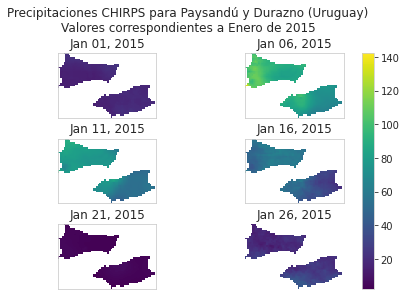

In [32]:
# Buscar precipitaciones del producto CHIRPS para todas las péntadas en Enero de 2015 
# para los departamentos de Paysandú y Durazno (Uruguay).
fecha_desde     = dateutil.parser.parse("2015-01-01").isoformat()
fecha_hasta     = dateutil.parser.parse("2015-01-31").isoformat()
url_rasters     = f"{base_url}/chirps/P/{fecha_desde}/{fecha_hasta}"
zona_geojson    = os.getcwd() + "/data/ZonasEjemplo.geojson"
fechas, rasters = consumir_servicio_espacial(url=url_rasters, usuario=usuario_default, clave=clave_default,
                                         archivo_geojson_zona=zona_geojson, raster_var_tag='prcp')
                                                     
# Graficar rasters de precipitaciones derivadas de CHIRPS.
figure, axes = plt.subplots(nrows=math.ceil(len(fechas)/2), ncols=1+(1%len(fechas)), 
                            constrained_layout=True)
_ = figure.suptitle('Precipitaciones CHIRPS para Paysandú y Durazno (Uruguay)\n'
                    'Valores correspondientes a Enero de 2015')

for ax, fecha, raster in zip(figure.get_axes(), fechas, rasters):
    __ = ax.set_title(fecha.strftime("%b %d, %Y")), ax.set_xticks([]), ax.set_yticks([])
    im = ax.imshow(raster if len(rasters) > 1 else rasters, vmin=rasters.min(), vmax=rasters.max(), cmap='viridis')

_ = figure.colorbar(im, ax=figure.get_axes())

plt.axis('off')
plt.show()


Además de poder descargar este producto en formato *raster*, también es posible extraer series temporales de valores para un conjunto de puntos (uno o más) o polígonos (uno o más). En el caso de la extracción para un conjunto de puntos, la respuesta devuelta por el servicio es una serie temporal de valores para cada punto dentro del rango de fechas especificado. En el caso de que la extracción sea realizada para un conjunto de polígonos, la respuesta devuelta por el servicio es una serie temporal de *estadísticos* (media, mediana, desvío estándar, desviación mediana absoluta, mínimo, máximo y los percentiles correspondientes al 25% y 75%) para cada polígono dentro del rango de fechas especificado.

Los puntos o polígonos deben especificarse en formato GeoJSON [17]. Además, cada punto o polígono debe tener asociado al menos un atributo para que el servicio pueda devolver una respuesta en la cual se puedan identificar cada una de las geometrías (puntos o polígonos). Por ejemplo, en caso de que los polígonos correspondan a localidades, el archivo GeoJSON podría contener atributos indicando el código de localidad o su nombre. Para el caso de los puntos, se podría indicar un nombre asociado a cada una de las ubicaciones, un código o los atributos que el usuario desee agregar.

*Ruta*: /chirps/serie_temporal/{periodo}/{fecha_desde:date}/{fecha_hasta:date}

*Método*: POST

*Parámetros*: 

  * periodo: período de agregación temporal de los datos (P: péntadas o M: mes); 
  * fecha_desde: fecha de inicio del período a consultar (en formato ISO-8601 [20]); 
  * fecha_hasta: fecha de fin del período a consultar (en formato ISO-8601 [20]).
  
*Parámetros del cuerpo del request*:
  
  * zona.geojson: string de formato GeoJSON que representa los puntos o polígonos sobre los cuales se efectuará la consulta.
  
*Respuesta*:
  
El servicio devuelve una respuesta en formato JSON, la cual puede convertirse a un formato tabular. La respuesta contiene los datos provistos por el usuario para cada una de las geometrías y los siguientes campos, según el usuario haya especificado puntos o polígonos:

[
  {
    ...
    <atributos provistos por el usuario para cada punto o polígono>
    ...,
    estadístico: string (solamente para el caso de polígonos, ver detalle a continuación),
    fecha: date (fecha dentro del rango de fechas especificadas por el usuario),
    valor: float (valor asociado al punto o polígono para la fecha especificada - y al estadístico en el caso de polígonos)
  }
]

Los estadísticos devueltos para el caso de las consultas asociadas a los polígonos se codifican de la siguiente manera:

  * 0%: mínimo valor dentro del polígono
  * 25%: percentil 25 de los valores dentro del polígono
  * 50%: mediana de los valores dentro del polígono
  * 75%: percentil 75 de los valores dentro del polígono
  * 100%: máximo valor dentro del polígono
  * Media: media de los valores dentro del polígono
  * Desvio: desvío estándar de los valores dentro del polígono
  * MAD: desvío mediano absoluto de los valores dentro del polígono
  
A continuación se presentan dos ejemplos: una consulta para puntos y otra para polígonos. Para la consulta basada en puntos, cada uno de ellos tiene asociado un nombre que identifica la ubicación. Para el caso de los polígonos, cada uno de ellos tiene asociado un nombre que representa una provincia de Argentina. Se presenta primero el ejemplo para ubicaciones puntuales.

In [33]:
# Buscar precipitación acumulada mensual para el primer trimestre de 2019 en 4 ubicaciones puntuales
fecha_desde = dateutil.parser.parse("2019-01-01").isoformat()
fecha_hasta = dateutil.parser.parse("2019-01-31").isoformat()
url_chirps = f"{base_url}/chirps/serie_temporal/M/{fecha_desde}/{fecha_hasta}"
zona_geojson = os.getcwd() + "/data/PuntosEjemplo.geojson" 
datos_prcp = consumir_servicio_espacial_serie_temporal(url=url_chirps,
                                                       usuario=usuario_default, clave=clave_default,
                                                       archivo_geojson_zona=zona_geojson)
# Mostrar datos en formato tabular
print(datos_prcp.to_markdown(tablefmt="github", showindex=False))

| nombre   | fecha      |   valor |
|----------|------------|---------|
| Lugar 1  | 2019-01-01 | 224.75  |
| Lugar 2  | 2019-01-01 | 157.652 |
| Lugar 3  | 2019-01-01 | 297.594 |
| Lugar 4  | 2019-01-01 | 136.782 |


Finalmente, se presenta un ejemplo para 3 polígonos correspondientes a zonas dentro de provincias argentinas (Buenos Aires, Santa Fe y Córdoba).

In [34]:
# Buscar precipitación acumulada mensual para el primer bimestre de 2019 en 3 provincias Argentinas
fecha_desde = dateutil.parser.parse("2019-01-01").isoformat()
fecha_hasta = dateutil.parser.parse("2019-01-31").isoformat()
url_chirps = f"{base_url}/chirps/serie_temporal/M/{fecha_desde}/{fecha_hasta}"
zona_geojson = os.getcwd() + "/data/PoligonosEjemplo.geojson" 
datos_prcp = consumir_servicio_espacial_serie_temporal(url=url_chirps,
                                                       usuario=usuario_default, clave=clave_default,
                                                       archivo_geojson_zona=zona_geojson)
# Mostrar datos en formato tabular
print(datos_prcp.to_markdown(tablefmt="github", showindex=False))

| nombre       | estadistico   | fecha      |    valor |
|--------------|---------------|------------|----------|
| Buenos Aires | 0%            | 2019-01-01 | 173.069  |
| Buenos Aires | 25%           | 2019-01-01 | 192.703  |
| Buenos Aires | 50%           | 2019-01-01 | 199.976  |
| Buenos Aires | 75%           | 2019-01-01 | 213.994  |
| Buenos Aires | 100%          | 2019-01-01 | 267.478  |
| Buenos Aires | Media         | 2019-01-01 | 204.908  |
| Buenos Aires | Desvio        | 2019-01-01 |  17.532  |
| Buenos Aires | MAD           | 2019-01-01 |  13.5045 |
| Cordoba      | 0%            | 2019-01-01 | 104.262  |
| Cordoba      | 25%           | 2019-01-01 | 141.151  |
| Cordoba      | 50%           | 2019-01-01 | 162.954  |
| Cordoba      | 75%           | 2019-01-01 | 182.12   |
| Cordoba      | 100%          | 2019-01-01 | 256.618  |
| Cordoba      | Media         | 2019-01-01 | 166.119  |
| Cordoba      | Desvio        | 2019-01-01 |  33.4216 |
| Cordoba      | MAD           

### 4.7.2. Índices de sequía basados en precipitaciones estimadas usando el producto CHIRPS

Este servicio permite consultar valores del índice de sequía SPI calculado en base a precipitaciones estimadas por el producto CHIRPS [21]. El servicio devuelve a) valores de SPI-ET y b) percentiles de precipitación acumulada para la escala temporal "ET". En ambos casos los valores devueltos están disponibles para escalas temporales de 3, 6 y 12 meses. En la actualidad, los valores están disponibles para períodos que finalicen entre el 2017-01-01 y la actualidad (por ejemplo el primer período para el cual el SPI-3 está disponible es el comprendido entre 2016-10-06 al 2017-01-05). Se proveen datos para cualquier aŕea incluida dentro del CRC-SAS, la cual debe especificarse en formato GeoJSON [17]. Para limitar el volumen de datos a transferir por medio del servicio, el área de la zona especificada no debe exceder los 2.000.000 km^2^.

El servicio devuelve como respuesta un stream de datos binarios correspondiente a un archivo de formato NetCDF [18]. Dicho archivo NetCDF tiene la siguiente estructura de dimensiones y variables:

  * Sistema de coordenadas: 
    * Latitud/Longitud: sistema de coordenadas expresadas en grados decimales;
    * String de proyección: +proj=longlat +datum=WGS84 +no_defs +ellps=WGS84 +towgs84=0,0,0;
    * Código EPSG: 4326.
  * Dimensiones: 
    * longitude: coordenada X (o longitud) expresada en grados decimales;
    * latitude: coordenada Y (o latitud) expresada en grados decimales;
    * time: cantidad de días desde el 1 de Enero de 1970 (día 0); corresponde a la fecha de inicio de la péntada o mes asociado a la capa de datos.
  * Variables: 
    * spi | percentile: valor de índice de sequía SPI o percentil calculado a partir de precipitaciones extraídas del producto CHIRPS, para la escala temporal especificada.
    
Con el propósito de facilitar la manipulación de los datos devueltos (que requiere conocimiento sobre archivos NetCDF), se recomienda enfáticamente utilizar la función *ConsumirServicioEspacial* provista al inicio del documento. Esta función permite invocar el servicio y obtener directamente un objeto de tipo *numpy.ma.core.MaskedArray* [19].

*Ruta*: /chirps/{producto:string}/{escala:int}/{fecha_desde:date}/{fecha_hasta:date}

*Método*: POST

*Parámetros*: 

  * producto: { spi = SPI, percentile = percentil asociado al monto de precipitaciones acumuladas en el período };
  * escala: escala temporal "ET" de agregación (en meses; 3, 6 o 12) del índice de sequía SPI o percentil;
  * fecha_desde: fecha de inicio del período a consultar (en formato ISO-8601 [20]); 
  * fecha_hasta: fecha de fin del período a consultar (en formato ISO-8601 [20]).
  
*Parámetros del cuerpo del request*:
  
  * zona.geojson: string de formato GeoJSON que representa la zona sobre la cual se efectuará la consulta.
  
*Respuesta*: Stream binario correspondiente a un archivo NetCDF (ver descripción en párrafos anteriores).

*Ejemplo*:

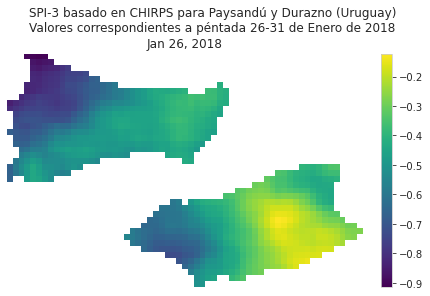

In [35]:
# Buscar los valores de SPI-3 para una péntada de Enero de 2018 para los departamentos de Paysandú y Durazno (Uruguay).
# Dado que CHIRPS se actualiza por péntadas, el dato que estamos buscando es el que finaliza en la
# sexta péntada de Enero de 2018. Es decir, la péntada que va desde 2018-01-26 a 2018-01-31.
fecha_desde     = dateutil.parser.parse("2018-01-26").isoformat()
fecha_hasta     = dateutil.parser.parse("2018-01-31").isoformat()
# Para buscar SPI se utiliza la ruta indicada en la línea siguiente. Si se desea buscar percentiles,
# se debe reemplazar "spi" por "percentile" en la ruta.
url_rasters     = f"{base_url}/chirps/spi/3/{fecha_desde}/{fecha_hasta}"
zona_geojson    = os.getcwd() + "/data/ZonasEjemplo.geojson"
fechas, rasters = consumir_servicio_espacial(url=url_rasters, usuario=usuario_default, clave=clave_default,
                                            archivo_geojson_zona=zona_geojson, raster_var_tag='spi')
                                                     
# Graficar rasters de SPI-3.
figure, axes = plt.subplots(nrows=math.ceil(len(fechas)/2), ncols=1+(1%len(fechas)), 
                            constrained_layout=True)
_ = figure.suptitle('SPI-3 basado en CHIRPS para Paysandú y Durazno (Uruguay)\n'
                    'Valores correspondientes a péntada 26-31 de Enero de 2018')

for ax, fecha, raster in zip(figure.get_axes(), fechas, rasters):
    __ = ax.set_title(fecha.strftime("%b %d, %Y")), ax.set_xticks([]), ax.set_yticks([])
    im = ax.imshow(raster, vmin=rasters.min(), vmax=rasters.max(), cmap='viridis')

_ = figure.colorbar(im, ax=figure.get_axes())

plt.axis('off')
plt.show()


Además de poder descargar este producto en formato *raster*, también es posible extraer series temporales de valores para un conjunto de puntos (uno o más) o polígonos (uno o más). En el caso de la extracción para un conjunto de puntos, la respuesta devuelta por el servicio es una serie temporal de valores para cada punto dentro del rango de fechas especificado. En el caso de que la extracción sea realizada para un conjunto de polígonos, la respuesta devuelta por el servicio es una serie temporal de *estadísticos* (media, mediana, desvío estándar, desviación mediana absoluta, mínimo, máximo y los percentiles correspondientes al 25% y 75%) para cada polígono dentro del rango de fechas especificado.

Los puntos o polígonos deben especificarse en formato GeoJSON [17]. Además, cada punto o polígono debe tener asociado al menos un atributo para que el servicio pueda devolver una respuesta en la cual se puedan identificar cada una de las geometrías (puntos o polígonos). Por ejemplo, en caso de que los polígonos correspondan a localidades, el archivo GeoJSON podría contener atributos indicando el código de localidad o su nombre. Para el caso de los puntos, se podría indicar un nombre asociado a cada una de las ubicaciones, un código o los atributos que el usuario desee agregar.

*Ruta*: /chirps/serie_temporal/{producto:string}/{escala:int}/{fecha_desde:date}/{fecha_hasta:date}

*Método*: POST

*Parámetros*: 

  * producto: { spi = SPI, percentile = percentil asociado al monto de precipitaciones acumuladas en el período };
  * escala: escala temporal "ET" de agregación (en meses; 3, 6 o 12) del índice de sequía SPI o percentil;
  * fecha_desde: fecha de inicio del período a consultar (en formato ISO-8601 [20]); 
  * fecha_hasta: fecha de fin del período a consultar (en formato ISO-8601 [20]).
  
*Parámetros del cuerpo del request*:
  
  * zona.geojson: string de formato GeoJSON que representa los puntos o polígonos sobre los cuales se efectuará la consulta.
  
*Respuesta*:
  
El servicio devuelve una respuesta en formato JSON, la cual puede convertirse a un formato tabular. La respuesta contiene los datos provistos por el usuario para cada una de las geometrías y los siguientes campos, según el usuario haya especificado puntos o polígonos:

[
  {
    ...
    <atributos provistos por el usuario para cada punto o polígono>
    ...,
    estadístico: string (solamente para el caso de polígonos, ver detalle a continuación),
    fecha: date (fecha dentro del rango de fechas especificadas por el usuario),
    valor: float (valor asociado al punto o polígono para la fecha especificada - y al estadístico en el caso de polígonos)
  }
]

Los estadísticos devueltos para el caso de las consultas asociadas a los polígonos se codifican de la siguiente manera:

  * 0%: mínimo valor dentro del polígono
  * 25%: percentil 25 de los valores dentro del polígono
  * 50%: mediana de los valores dentro del polígono
  * 75%: percentil 75 de los valores dentro del polígono
  * 100%: máximo valor dentro del polígono
  * Media: media de los valores dentro del polígono
  * Desvio: desvío estándar de los valores dentro del polígono
  * MAD: desvío mediano absoluto de los valores dentro del polígono
  
A continuación se presentan dos ejemplos: una consulta para puntos y otra para polígonos. Para la consulta basada en puntos, cada uno de ellos tiene asociado un nombre que identifica la ubicación. Para el caso de los polígonos, cada uno de ellos tiene asociado un nombre que representa una provincia de Argentina. Se presenta primero el ejemplo para ubicaciones puntuales.

In [36]:
# Buscar SPI-3 para las primeras 3 péntadas de Enero de 2019 en 4 ubicaciones puntuales
fecha_desde = dateutil.parser.parse("2019-01-01").isoformat()
fecha_hasta = dateutil.parser.parse("2019-01-31").isoformat()
url_chirps = f"{base_url}/chirps/serie_temporal/spi/3/{fecha_desde}/{fecha_hasta}"
zona_geojson = os.getcwd() + "/data/PuntosEjemplo.geojson" 
datos_spi3 = consumir_servicio_espacial_serie_temporal(url=url_chirps,
                                                       usuario=usuario_default, clave=clave_default,
                                                       archivo_geojson_zona=zona_geojson)
# Mostrar datos en formato tabular
print(datos_spi3.to_markdown(tablefmt="github", showindex=False))

| nombre   | fecha      |   valor |
|----------|------------|---------|
| Lugar 1  | 2019-01-01 |  0.4608 |
| Lugar 1  | 2019-01-06 |  0.7708 |
| Lugar 1  | 2019-01-11 |  1.0258 |
| Lugar 1  | 2019-01-16 |  0.9738 |
| Lugar 1  | 2019-01-21 |  1.6659 |
| Lugar 1  | 2019-01-26 |  1.8058 |
| Lugar 2  | 2019-01-01 | -0.1871 |
| Lugar 2  | 2019-01-06 |  0.3659 |
| Lugar 2  | 2019-01-11 |  0.4351 |
| Lugar 2  | 2019-01-16 |  0.4423 |
| Lugar 2  | 2019-01-21 |  0.7645 |
| Lugar 2  | 2019-01-26 |  0.4739 |
| Lugar 3  | 2019-01-01 |  1.2455 |
| Lugar 3  | 2019-01-06 |  1.4148 |
| Lugar 3  | 2019-01-11 |  1.816  |
| Lugar 3  | 2019-01-16 |  1.7174 |
| Lugar 3  | 2019-01-21 |  2.1973 |
| Lugar 3  | 2019-01-26 |  2.9024 |
| Lugar 4  | 2019-01-01 |  0.9351 |
| Lugar 4  | 2019-01-06 |  1.2654 |
| Lugar 4  | 2019-01-11 |  1.9639 |
| Lugar 4  | 2019-01-16 |  1.5008 |
| Lugar 4  | 2019-01-21 |  1.8306 |
| Lugar 4  | 2019-01-26 |  1.3421 |


Finalmente, se presenta un ejemplo para 3 polígonos correspondientes a zonas dentro de provincias argentinas (Buenos Aires, Santa Fe y Córdoba).

In [37]:
# Buscar SPI-3 para las primeras 2 péntadas de Enero de 2019 en 3 provincias Argentinas
fecha_desde = dateutil.parser.parse("2019-01-01").isoformat()
fecha_hasta = dateutil.parser.parse("2019-01-31").isoformat()
url_chirps = f"{base_url}/chirps/serie_temporal/spi/3/{fecha_desde}/{fecha_hasta}"
zona_geojson = os.getcwd() + "/data/PoligonosEjemplo.geojson" 
datos_spi3 = consumir_servicio_espacial_serie_temporal(url=url_chirps,
                                                       usuario=usuario_default, clave=clave_default,
                                                       archivo_geojson_zona=zona_geojson)
# Mostrar datos en formato tabular
print(datos_spi3.to_markdown(tablefmt="github", showindex=False))

| nombre       | estadistico   | fecha      |   valor |
|--------------|---------------|------------|---------|
| Buenos Aires | 0%            | 2019-01-01 | -0.078  |
| Buenos Aires | 25%           | 2019-01-01 |  0.2517 |
| Buenos Aires | 50%           | 2019-01-01 |  0.398  |
| Buenos Aires | 75%           | 2019-01-01 |  0.5374 |
| Buenos Aires | 100%          | 2019-01-01 |  0.8423 |
| Buenos Aires | Media         | 2019-01-01 |  0.3911 |
| Buenos Aires | Desvio        | 2019-01-01 |  0.1849 |
| Buenos Aires | MAD           | 2019-01-01 |  0.2142 |
| Buenos Aires | 0%            | 2019-01-06 |  0.4098 |
| Buenos Aires | 25%           | 2019-01-06 |  0.5933 |
| Buenos Aires | 50%           | 2019-01-06 |  0.7258 |
| Buenos Aires | 75%           | 2019-01-06 |  0.8388 |
| Buenos Aires | 100%          | 2019-01-06 |  1.1238 |
| Buenos Aires | Media         | 2019-01-06 |  0.7293 |
| Buenos Aires | Desvio        | 2019-01-06 |  0.1654 |
| Buenos Aires | MAD           | 2019-01-06 |  0

### 4.7.3. Pronósticos de precipitación y sequía a 15 días usando el producto CHIRPS-GEFS

La evolución esperada de la sequía en las próximas dos semanas se basa en un pronóstico de lluvias para los proximos 15 días generado por el Climate Hazards Center de los Estados Unidos, la misma institución que genera los campos de precipitación CHIRPS. El pronóstico está basado en el modelo numérico Global Ensemble Forecast System o GEFS (https://www.esrl.noaa.gov/psd/forecasts/reforecast2/) desarrollado por el Centro Nacional de Predicción Ambiental (NCEP, por sus siglas en inglés de los Estados Unidos) a través del modelo Global Ensemble Forecast System o GEFS. El Climate Hazards Center realiza un proceso de calibración (o remoción del sesgo) en los valores pronosticados [22].

A partir de esta información de pronósticos para 15 días (o 3 péntadas en términos del producto CHIRPS), se construye en ensamble de capas de datos considerando 15 péntadas de datos observados (2 meses y medio) y las 3 péntadas pronosticadas. Este ensamble constituye una capa de 18 péntadas de precipitaciones las cuales son acumuladas con el fin de calcular valores de SPI-3 y percentiles de precipitación acumulada del mismo modo que se realiza para el producto CHIRPS.

El servicio permite consultar a) valores de precipitación pronosticada, b) ensamble de precipitación acumulada observada/pronosticada, c) valores de SPI y d) percentiles de precipitación acumulada para la escala temporal de 3 meses. Se proveen datos para cualquier aŕea incluida dentro del CRC-SAS, la cual debe especificarse en formato GeoJSON [17]. Para limitar el volumen de datos a transferir por medio del servicio, el área de la zona especificada no debe exceder los 2.000.000 km^2^.

El servicio devuelve como respuesta un stream de datos binarios correspondiente a un archivo de formato NetCDF [18]. Dicho archivo NetCDF tiene la siguiente estructura de dimensiones y variables:

  * Sistema de coordenadas: 
    * Latitud/Longitud: sistema de coordenadas expresadas en grados decimales;
    * String de proyección: +proj=longlat +datum=WGS84 +no_defs +ellps=WGS84 +towgs84=0,0,0;
    * Código EPSG: 4326.
  * Dimensiones: 
    * longitude: coordenada X (o longitud) expresada en grados decimales;
    * latitude: coordenada Y (o latitud) expresada en grados decimales;
    * time: cantidad de días desde el 1 de Enero de 1970 (día 0); corresponde a la fecha de inicio de la péntada o mes asociado a la capa de datos.
  * Variables: 
    * forecasted_total | total | spi | percentile: valor de precipitación pronosticada a 15 días (forecasted_total), ensamble de precipitación acumulada observada/pronosticada (total), índice SPI (spi) o percentil asociado, para la escala temporal especificada (percentile).
    
Con el propósito de facilitar la manipulación de los datos devueltos (que requiere conocimiento sobre archivos NetCDF), se recomienda enfáticamente utilizar la función *ConsumirServicioEspacial* provista al inicio del documento. Esta función permite invocar el servicio y obtener directamente un objeto de tipo *raster* [19].

*Ruta*: /chirps/pronostico/{producto:string}/{escala:int}/{fecha_desde:date}/{fecha_hasta:date}

*Método*: POST

*Parámetros*: 

  * producto: { forecasted_total = valor de precipitación pronosticada a 15 días, total = ensamble de precipitación acumulada observada/pronosticada, spi = índice SPI, percentile = percentil asociado, para la escala temporal especificada };
  * escala: escala temporal "ET" de agregación (por el momento solamente 3 meses);
  * fecha_desde: fecha de inicio del período a consultar (en formato ISO-8601 [20]); 
  * fecha_hasta: fecha de fin del período a consultar (en formato ISO-8601 [20]).
  
*Parámetros del cuerpo del request*:
  
  * zona.geojson: string de formato GeoJSON que representa la zona sobre la cual se efectuará la consulta.
  
*Respuesta*: Stream binario correspondiente a un archivo NetCDF (ver descripción en párrafos anteriores).

*Ejemplo*:

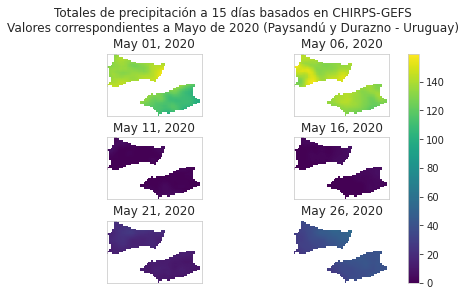

In [38]:
# Buscar pronosticado de lluvias a 15 días usando CHIRPS-GEFS 
# para Mayo de 2020 (departamentos de Paysandú y Durazno (UY).
fecha_desde     = dateutil.parser.parse("2020-05-01").isoformat()
fecha_hasta     = dateutil.parser.parse("2020-05-31").isoformat()
url_chirps      = f"{base_url}/chirps/pronostico/forecasted_total/3/{fecha_desde}/{fecha_hasta}"
zona_geojson    = os.getcwd() + "/data/ZonasEjemplo.geojson"
fechas, rasters = consumir_servicio_espacial(url=url_chirps, usuario=usuario_default, clave=clave_default,
                                            archivo_geojson_zona=zona_geojson, raster_var_tag='forecasted_total')
                                                     
# Graficar rasters de CHIRPS
figure, axes = plt.subplots(nrows=math.ceil(len(fechas)/2), ncols=1+(1%len(fechas)), 
                            constrained_layout=True)
_ = figure.suptitle('Totales de precipitación a 15 días basados en CHIRPS-GEFS\n'
                    'Valores correspondientes a Mayo de 2020 (Paysandú y Durazno - Uruguay)')

for ax, fecha, raster in zip(figure.get_axes(), fechas, rasters):
    __ = ax.set_title(fecha.strftime("%b %d, %Y")), ax.set_xticks([]), ax.set_yticks([])
    im = ax.imshow(raster if len(rasters) > 1 else rasters, vmin=rasters.min(), vmax=rasters.max(), cmap='viridis')

_ = figure.colorbar(im, ax=figure.get_axes())

plt.axis('off')
plt.show()

## 4.8. Índice de Stress Evaporativo (ESI) y percentiles derivados

El Índice de Estrés Evaporativo (o, en adelante, ESI por sus siglas en inglés) identifica regiones donde la vegetación está sufriendo estrés por falta de agua. El ESI se produce semanalmente con una resolución espacial de aproximadamente 5x5 km y cubre todo el globo. Este producto describe la humedad del suelo en todo el paisaje sin utilizar datos de lluvia observados. Esto es fundamental en las regiones en desarrollo y otras partes del mundo que carecen de suficientes observaciones terrestres de las precipitaciones. Al no utilizar datos de lluvias, el ESI es útil para estudiar cómo los cultivos responden al riego. 

El ESI es especialmente útil para predecir un fenómeno llamado *sequías repentinas* (o *flash droughts*). A diferencia de las sequías típicas que pueden tardar meses o años en desarrollarse, las sequías repentinas ocurren mucho más repentinamente y pueden dañar los cultivos en cuestión de semanas, mucho antes de que el estrés cause signos visibles de daño. Las *sequías repentinas* generalmente son provocadas por períodos prolongados de condiciones cálidas, secas y ventosas que agotan rápidamente la humedad del suelo. La ocurrencia de tasas reducidas de pérdida de agua por evapotranspiracion puede estimarse mediante el uso de la temperatura de la superficie de la tierra antes de que estas pérdidas se reflejen en disminuciones en la salud o *verdor* de la vegetación (por ejemplo los índices de vegetación NDVI o EVI) [22].

Este servicio permite consultar valores de ESI y los percentiles asociados calculados en base al período de referencia 2002-2019. El servicio devuelve a) valores de ESI y b) percentiles de ESI para la escala temporal "ET". En ambos casos los valores devueltos están disponibles para escalas temporales de 4 y 12 semanas. Se proveen datos para cualquier aŕea incluida dentro del CRC-SAS, la cual debe especificarse en formato GeoJSON [17]. Para limitar el volumen de datos a transferir por medio del servicio, el área de la zona especificada no debe exceder los 2.000.000 km^2^.

El servicio devuelve como respuesta un stream de datos binarios correspondiente a un archivo de formato NetCDF [18]. Dicho archivo NetCDF tiene la siguiente estructura de dimensiones y variables:

  * Sistema de coordenadas: 
    * Latitud/Longitud: sistema de coordenadas expresadas en grados decimales;
    * String de proyección: +proj=longlat +datum=WGS84 +no_defs +ellps=WGS84 +towgs84=0,0,0;
    * Código EPSG: 4326.
  * Dimensiones: 
    * longitude: coordenada X (o longitud) expresada en grados decimales;
    * latitude: coordenada Y (o latitud) expresada en grados decimales;
    * time: cantidad de días desde el 1 de Enero de 1970 (día 0); corresponde a la fecha de inicio de la péntada o mes asociado a la capa de datos.
  * Variables: 
    * esi | percentiles: valor de índice ESI o percentil asociado, para la escala temporal especificada.
    
Con el propósito de facilitar la manipulación de los datos devueltos (que requiere conocimiento sobre archivos NetCDF), se recomienda enfáticamente utilizar la función *ConsumirServicioEspacial* provista al inicio del documento. Esta función permite invocar el servicio y obtener directamente un objeto de tipo *raster* [19].

*Ruta*: /esi/{producto:string}/{escala:string}/{fecha_desde:date}/{fecha_hasta:date}

*Método*: POST

*Parámetros*: 

  * producto: { esi = índice ESI, percentiles = percentils asociado índice ESI };
  * escala: escala temporal "ET" de agregación del ESI o percentiles { 4WK = 4 semanas, 12WK = 12 semanas };
  * fecha_desde: fecha de inicio del período a consultar (en formato ISO-8601 [20]); 
  * fecha_hasta: fecha de fin del período a consultar (en formato ISO-8601 [20]).
  
*Parámetros del cuerpo del request*:
  
  * zona.geojson: string de formato GeoJSON que representa la zona sobre la cual se efectuará la consulta.
  
*Respuesta*: Stream binario correspondiente a un archivo NetCDF (ver descripción en párrafos anteriores).

*Ejemplo*:

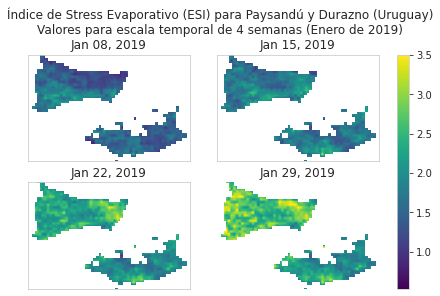

In [39]:
# Buscar ESI con escala temporal de 4 semanas para Enero de 2019 (departamentos de Paysandú y Durazno (UY)).
fecha_desde     = dateutil.parser.parse("2019-01-01").isoformat()
fecha_hasta     = dateutil.parser.parse("2019-01-31").isoformat()
url_esi         = f"{base_url}/esi/esi/4WK/{fecha_desde}/{fecha_hasta}"
zona_geojson    = os.getcwd() + "/data/ZonasEjemplo.geojson"
fechas, rasters = consumir_servicio_espacial(url=url_esi, usuario=usuario_default, clave=clave_default,
                                            archivo_geojson_zona=zona_geojson, raster_var_tag='esi')
                                                     
# Graficar rasters de ESI
figure, axes = plt.subplots(nrows=math.ceil(len(fechas)/2), ncols=1+(1%len(fechas)), 
                            constrained_layout=True)
_ = figure.suptitle('Índice de Stress Evaporativo (ESI) para Paysandú y Durazno (Uruguay)\n'
                    'Valores para escala temporal de 4 semanas (Enero de 2019)')

for ax, fecha, raster in zip(figure.get_axes(), fechas, rasters):
    __ = ax.set_title(fecha.strftime("%b %d, %Y")), ax.set_xticks([]), ax.set_yticks([])
    im = ax.imshow(raster if len(rasters) > 1 else rasters, vmin=rasters.min(), vmax=rasters.max(), cmap='viridis')

_ = figure.colorbar(im, ax=figure.get_axes())

plt.axis('off')
plt.show()

Además de poder descargar este producto en formato *raster*, también es posible extraer series temporales de valores para un conjunto de puntos (uno o más) o polígonos (uno o más). En el caso de la extracción para un conjunto de puntos, la respuesta devuelta por el servicio es una serie temporal de valores para cada punto dentro del rango de fechas especificado. En el caso de que la extracción sea realizada para un conjunto de polígonos, la respuesta devuelta por el servicio es una serie temporal de *estadísticos* (media, mediana, desvío estándar, desviación mediana absoluta, mínimo, máximo y los percentiles correspondientes al 25% y 75%) para cada polígono dentro del rango de fechas especificado.

Los puntos o polígonos deben especificarse en formato GeoJSON [17]. Además, cada punto o polígono debe tener asociado al menos un atributo para que el servicio pueda devolver una respuesta en la cual se puedan identificar cada una de las geometrías (puntos o polígonos). Por ejemplo, en caso de que los polígonos correspondan a localidades, el archivo GeoJSON podría contener atributos indicando el código de localidad o su nombre. Para el caso de los puntos, se podría indicar un nombre asociado a cada una de las ubicaciones, un código o los atributos que el usuario desee agregar.

*Ruta*: /esi/serie_temporal/{producto:string}/{escala:string}/{fecha_desde:date}/{fecha_hasta:date}

*Método*: POST

*Parámetros*: 

  * producto: { esi = índice ESI, percentiles = percentils asociado índice ESI };
  * escala: escala temporal "ET" de agregación del ESI o percentiles { 4WK = 4 semanas, 12WK = 12 semanas };
  * fecha_desde: fecha de inicio del período a consultar (en formato ISO-8601 [20]); 
  * fecha_hasta: fecha de fin del período a consultar (en formato ISO-8601 [20]).
  
*Parámetros del cuerpo del request*:
  
  * zona.geojson: string de formato GeoJSON que representa los puntos o polígonos sobre los cuales se efectuará la consulta.
  
*Respuesta*:
  
El servicio devuelve una respuesta en formato JSON, la cual puede convertirse a un formato tabular. La respuesta contiene los datos provistos por el usuario para cada una de las geometrías y los siguientes campos, según el usuario haya especificado puntos o polígonos:

[
  {
    ...
    <atributos provistos por el usuario para cada punto o polígono>
    ...,
    estadístico: string (solamente para el caso de polígonos, ver detalle a continuación),
    fecha: date (fecha dentro del rango de fechas especificadas por el usuario),
    valor: float (valor asociado al punto o polígono para la fecha especificada - y al estadístico en el caso de polígonos)
  }
]

Los estadísticos devueltos para el caso de las consultas asociadas a los polígonos se codifican de la siguiente manera:

  * 0%: mínimo valor dentro del polígono
  * 25%: percentil 25 de los valores dentro del polígono
  * 50%: mediana de los valores dentro del polígono
  * 75%: percentil 75 de los valores dentro del polígono
  * 100%: máximo valor dentro del polígono
  * Media: media de los valores dentro del polígono
  * Desvio: desvío estándar de los valores dentro del polígono
  * MAD: desvío mediano absoluto de los valores dentro del polígono
  
A continuación se presentan dos ejemplos: una consulta para puntos y otra para polígonos. Para la consulta basada en puntos, cada uno de ellos tiene asociado un nombre que identifica la ubicación. Para el caso de los polígonos, cada uno de ellos tiene asociado un nombre que representa una provincia de Argentina. Se presenta primero el ejemplo para ubicaciones puntuales.

In [40]:
# Buscar ESI con escala de agregación de 4 semanas para Enero de 2019 en 4 ubicaciones puntuales
fecha_desde = dateutil.parser.parse("2019-01-01").isoformat()
fecha_hasta = dateutil.parser.parse("2019-01-31").isoformat()
url_chirps = f"{base_url}/esi/serie_temporal/esi/4WK/{fecha_desde}/{fecha_hasta}"
zona_geojson = os.getcwd() + "/data/PuntosEjemplo.geojson" 
datos_esi = consumir_servicio_espacial_serie_temporal(url=url_chirps,
                                                      usuario=usuario_default, clave=clave_default,
                                                      archivo_geojson_zona=zona_geojson)
# Mostrar datos en formato tabular
print(datos_esi.to_markdown(tablefmt="github", showindex=False))

| nombre   | fecha      |   valor |
|----------|------------|---------|
| Lugar 1  | 2019-01-08 |  1.6678 |
| Lugar 1  | 2019-01-15 |  1.7392 |
| Lugar 1  | 2019-01-22 |  2.1009 |
| Lugar 1  | 2019-01-29 |  2.74   |
| Lugar 2  | 2019-01-08 |  0.3689 |
| Lugar 2  | 2019-01-15 |  1.2818 |
| Lugar 2  | 2019-01-22 |  1.8459 |
| Lugar 2  | 2019-01-29 |  1.6372 |
| Lugar 3  | 2019-01-08 |  1.8288 |
| Lugar 3  | 2019-01-15 |  1.9126 |
| Lugar 3  | 2019-01-22 |  2.4142 |
| Lugar 3  | 2019-01-29 |  3.3442 |
| Lugar 4  | 2019-01-08 |  0.7941 |
| Lugar 4  | 2019-01-15 |  2.6321 |
| Lugar 4  | 2019-01-22 |  1.8936 |
| Lugar 4  | 2019-01-29 |  1.8996 |


Finalmente, se presenta un ejemplo para 3 polígonos correspondientes a zonas dentro de provincias argentinas (Buenos Aires, Santa Fe y Córdoba).

In [41]:
# Buscar ESI con escala de agregación de 4 semanas para la primera quincena de Enero de 2019 en 3 provincias Argentinas
fecha_desde = dateutil.parser.parse("2019-01-01").isoformat()
fecha_hasta = dateutil.parser.parse("2019-01-31").isoformat()
url_chirps = f"{base_url}/esi/serie_temporal/esi/4WK/{fecha_desde}/{fecha_hasta}"
zona_geojson = os.getcwd() + "/data/PoligonosEjemplo.geojson" 
datos_esi = consumir_servicio_espacial_serie_temporal(url=url_chirps,
                                                      usuario=usuario_default, clave=clave_default,
                                                      archivo_geojson_zona=zona_geojson)
# Mostrar datos en formato tabular
print(datos_esi.to_markdown(tablefmt="github", showindex=False))

| nombre       | estadistico   | fecha      |   valor |
|--------------|---------------|------------|---------|
| Buenos Aires | 0%            | 2019-01-08 |  0.8725 |
| Buenos Aires | 25%           | 2019-01-08 |  1.4398 |
| Buenos Aires | 50%           | 2019-01-08 |  1.6139 |
| Buenos Aires | 75%           | 2019-01-08 |  1.8178 |
| Buenos Aires | 100%          | 2019-01-08 |  2.6498 |
| Buenos Aires | Media         | 2019-01-08 |  1.6387 |
| Buenos Aires | Desvio        | 2019-01-08 |  0.2871 |
| Buenos Aires | MAD           | 2019-01-08 |  0.2732 |
| Buenos Aires | 0%            | 2019-01-15 |  1.1135 |
| Buenos Aires | 25%           | 2019-01-15 |  1.7065 |
| Buenos Aires | 50%           | 2019-01-15 |  1.9255 |
| Buenos Aires | 75%           | 2019-01-15 |  2.1792 |
| Buenos Aires | 100%          | 2019-01-15 |  3.5    |
| Buenos Aires | Media         | 2019-01-15 |  1.9667 |
| Buenos Aires | Desvio        | 2019-01-15 |  0.3736 |
| Buenos Aires | MAD           | 2019-01-15 |  0

## 4.9. Estimaciones de humedad del suelo y contenido del agua sub-superficial (GRACE).

Los productos resultantes de la misión GRACE (Gravity Recovery and Climate Experiment) - que forma parte de un proyecto conjunto entre la NASA (https://www.nasa.gov/) y la Agencia Espacial Alemana (https://www.dlr.de), abordan una de las carencias más importantes de los sistemas de monitoreo de sequía: “la falta de información objetiva acerca de humedad de suelo en capas profundas y los niveles de napa subterránea”. 

A partir del modelo de captación de superficie terrestre (CLSM – [24]) se han definido tres variables relevantes para el monitoreo de la sequía: humedad superficial del suelo (surface soil moisture – SFSM), humedad del suelo en la zona de raíces (root zone soil moisture – RTZSM) y almacenamiento de agua subterránea (groundwater storage – GWS). Estos tres productos están disponibles en el sitio https://nasagrace.unl.edu/ con frecuencia semanal y datos desde febrero de 2003 hasta la fecha. 

Este servicio permite consultar valores de los productos GRACE gws_inst - Groundwater Percentile (Contenido de agua subterránea, expresado en percentiles), rtzsm_inst - Root Zone Soil Moisture Percentile (Humedad del suelo en zona de raíces, expresada en percentiles), sfsm_inst - Surface Soil Moisture Percentile (Humedad superficial del suelo, expresada en percentiles) para cualquier área incluida dentro del CRC-SAS, la cual debe especificarse en formato GeoJSON [17]. Para limitar el volumen de datos a transferir por medio del servicio, el área de la zona especificada no debe exceder los 2.000.000 km^2^.

El servicio devuelve como respuesta un stream de datos binarios correspondiente a un archivo de formato NetCDF [18]. Dicho archivo NetCDF tiene la siguiente estructura de dimensiones y variables:

  * Sistema de coordenadas: 
    * Latitud/Longitud: sistema de coordenadas expresadas en grados decimales;
    * String de proyección: +proj=longlat +datum=WGS84 +no_defs +ellps=WGS84 +towgs84=0,0,0;
    * Código EPSG: 4326.
  * Dimensiones: 
    * longitude: coordenada X (o longitud) expresada en grados decimales;
    * latitude: coordenada Y (o latitud) expresada en grados decimales;
    * time: cantidad de días desde el 1 de Enero de 1970 (día 0); corresponde a la fecha de inicio de la péntada o mes asociado a la capa de datos.
  * Variables: 
    * gws_inst o rtzsm_inst o sfsm_inst: producto seleccionado, expresado en percentiles.
    
Con el propósito de facilitar la manipulación de los datos devueltos (que requiere conocimiento sobre archivos NetCDF), se recomienda enfáticamente utilizar la función *ConsumirServicioEspacial* provista al inicio del documento. Esta función permite invocar el servicio y obtener directamente un objeto de tipo *raster* [19].

*Ruta*: /grace/{producto:string}/{fecha_desde:date}/{fecha_hasta:date}

*Método*: POST

*Parámetros*: 

  * producto: 
    ** gws_inst: Groundwater Percentile (Contenido de agua subterránea, expresado en percentiles)
    ** rtzsm_inst: Root Zone Soil Moisture Percentile (Humedad del suelo en zona de raíces, expresada en percentiles)
    ** sfsm_inst: Surface Soil Moisture Percentile (Humedad superficial del suelo, expresada en percentiles)
  * fecha_desde: fecha de inicio del período a consultar (en formato ISO-8601 [20]); 
  * fecha_hasta: fecha de fin del período a consultar (en formato ISO-8601 [20]).
  
*Parámetros del cuerpo del request*:
  
  * zona.geojson: string de formato GeoJSON que representa la zona sobre la cual se efectuará la consulta.
  
*Respuesta*: Stream binario correspondiente a un archivo NetCDF (ver descripción en párrafos anteriores).

*Ejemplo*:


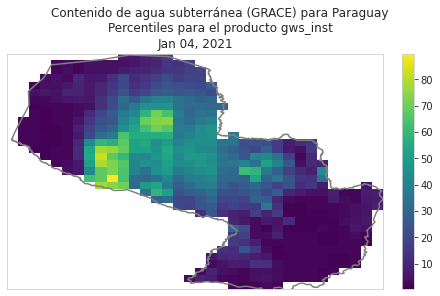

In [42]:
# Buscar GRACE para la primera quincena de Enero de 2021 (Paraguay - PY).
fecha_desde = dateutil.parser.parse("2021-01-01").isoformat()
fecha_hasta = dateutil.parser.parse("2021-01-15").isoformat()
url_grace = f"{base_url}/grace/gws_inst/{fecha_desde}/{fecha_hasta}"
zona_geojson = os.getcwd() + "/data/PY.geojson"
zona_gdf = gpd.read_file(zona_geojson)
grace_xr = consumir_servicio_espacial_xarray(url=url_grace, usuario=usuario_default, clave=clave_default,
                                             archivo_geojson_zona=zona_geojson)

# Definir fechas a graficar
fechas = [pd.to_datetime(str(t)) for t in grace_xr.gws_inst.time.values]
fechas = [fechas[0]]
                                                     
# Graficar rasters de GRACE
figure, axes = plt.subplots(nrows=math.ceil(len(fechas) / 2), ncols=1 + (1 % len(fechas)),
                            constrained_layout=True)
_ = figure.suptitle('Contenido de agua subterránea (GRACE) para Paraguay\n'
                    'Percentiles para el producto gws_inst')

for i, ax, fecha in zip(range(len(fechas)), figure.get_axes(), fechas):
    zona_gdf.boundary.plot(ax=ax, color='grey')
    grace_xr.gws_inst[i, :, :].plot.imshow(ax=ax, cbar_kwargs={'label': ''})
    __ = ax.set_title(fecha.strftime("%b %d, %Y"))
    ax.set_xticks([]), ax.xaxis.label.set_visible(False)
    ax.set_yticks([]), ax.yaxis.label.set_visible(False)

plt.show()

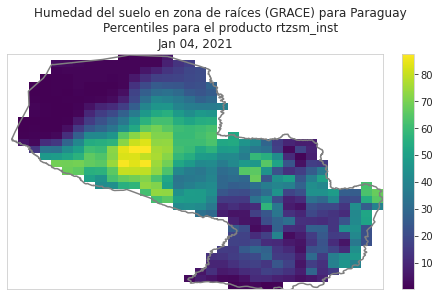

In [43]:
# Buscar GRACE para la primera quincena de Enero de 2021 (Paraguay - PY).
fecha_desde = dateutil.parser.parse("2021-01-01").isoformat()
fecha_hasta = dateutil.parser.parse("2021-01-15").isoformat()
url_grace = f"{base_url}/grace/rtzsm_inst/{fecha_desde}/{fecha_hasta}"
zona_geojson = os.getcwd() + "/data/PY.geojson"
zona_gdf = gpd.read_file(zona_geojson)
grace_xr = consumir_servicio_espacial_xarray(url=url_grace, usuario=usuario_default, clave=clave_default,
                                             archivo_geojson_zona=zona_geojson)

# Definir fechas a graficar
fechas = [pd.to_datetime(str(t)) for t in grace_xr.rtzsm_inst.time.values]
fechas = [fechas[0]]
                                                     
# Graficar rasters de GRACE
figure, axes = plt.subplots(nrows=math.ceil(len(fechas) / 2), ncols=1 + (1 % len(fechas)),
                            constrained_layout=True)
_ = figure.suptitle('Humedad del suelo en zona de raíces (GRACE) para Paraguay\n'
                    'Percentiles para el producto rtzsm_inst')

for i, ax, fecha in zip(range(len(fechas)), figure.get_axes(), fechas):
    zona_gdf.boundary.plot(ax=ax, color='grey')
    grace_xr.rtzsm_inst[i, :, :].plot.imshow(ax=ax, cbar_kwargs={'label': ''})
    __ = ax.set_title(fecha.strftime("%b %d, %Y"))
    ax.set_xticks([]), ax.xaxis.label.set_visible(False)
    ax.set_yticks([]), ax.yaxis.label.set_visible(False)

plt.show()

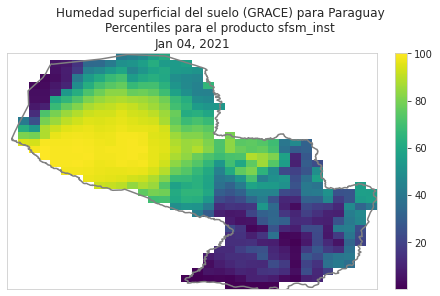

In [44]:
# Buscar GRACE para la primera quincena de Enero de 2021 (Paraguay - PY).
fecha_desde = dateutil.parser.parse("2021-01-01").isoformat()
fecha_hasta = dateutil.parser.parse("2021-01-15").isoformat()
url_grace = f"{base_url}/grace/sfsm_inst/{fecha_desde}/{fecha_hasta}"
zona_geojson = os.getcwd() + "/data/PY.geojson"
zona_gdf = gpd.read_file(zona_geojson)
grace_xr = consumir_servicio_espacial_xarray(url=url_grace, usuario=usuario_default, clave=clave_default,
                                             archivo_geojson_zona=zona_geojson)

# Definir fechas a graficar
fechas = [pd.to_datetime(str(t)) for t in grace_xr.sfsm_inst.time.values]
fechas = [fechas[0]]
                                                     
# Graficar rasters de GRACE
figure, axes = plt.subplots(nrows=math.ceil(len(fechas) / 2), ncols=1 + (1 % len(fechas)),
                            constrained_layout=True)
_ = figure.suptitle('Humedad superficial del suelo (GRACE) para Paraguay\n'
                    'Percentiles para el producto sfsm_inst')

for i, ax, fecha in zip(range(len(fechas)), figure.get_axes(), fechas):
    zona_gdf.boundary.plot(ax=ax, color='grey')
    grace_xr.sfsm_inst[i, :, :].plot.imshow(ax=ax, cbar_kwargs={'label': ''})
    __ = ax.set_title(fecha.strftime("%b %d, %Y"))
    ax.set_xticks([]), ax.xaxis.label.set_visible(False)
    ax.set_yticks([]), ax.yaxis.label.set_visible(False)

plt.show()

Además de poder descargar este producto en formato *raster*, también es posible extraer series temporales de valores para un conjunto de puntos (uno o más) o polígonos (uno o más). En el caso de la extracción para un conjunto de puntos, la respuesta devuelta por el servicio es una serie temporal de valores para cada punto dentro del rango de fechas especificado. En el caso de que la extracción sea realizada para un conjunto de polígonos, la respuesta devuelta por el servicio es una serie temporal de *estadísticos* (media, mediana, desvío estándar, desviación mediana absoluta, mínimo, máximo y los percentiles correspondientes al 25% y 75%) para cada polígono dentro del rango de fechas especificado.

Los puntos o polígonos deben especificarse en formato GeoJSON [17]. Además, cada punto o polígono debe tener asociado al menos un atributo para que el servicio pueda devolver una respuesta en la cual se puedan identificar cada una de las geometrías (puntos o polígonos). Por ejemplo, en caso de que los polígonos correspondan a localidades, el archivo GeoJSON podría contener atributos indicando el código de localidad o su nombre. Para el caso de los puntos, se podría indicar un nombre asociado a cada una de las ubicaciones, un código o los atributos que el usuario desee agregar.

*Ruta*: /grace/serie_temporal/{producto:string}/{fecha_desde:date}/{fecha_hasta:date}

*Método*: POST

*Parámetros*: 

  *producto: 
    ** gws_inst: Groundwater Percentile (Contenido de agua subterránea, expresado en percentiles)
    ** rtzsm_inst: Root Zone Soil Moisture Percentile (Humedad del suelo en zona de raíces, expresada en percentiles)
    ** sfsm_inst: Surface Soil Moisture Percentile (Humedad superficial del suelo, expresada en percentiles)
  * fecha_desde: fecha de inicio del período a consultar (en formato ISO-8601 [20]); 
  * fecha_hasta: fecha de fin del período a consultar (en formato ISO-8601 [20]).
  
*Parámetros del cuerpo del request*:
  
  * zona.geojson: string de formato GeoJSON que representa los puntos o polígonos sobre los cuales se efectuará la consulta.
  
*Respuesta*:
  
El servicio devuelve una respuesta en formato JSON, la cual puede convertirse a un formato tabular. La respuesta contiene los datos provistos por el usuario para cada una de las geometrías y los siguientes campos, según el usuario haya especificado puntos o polígonos:

[
  {
    ...
    <atributos provistos por el usuario para cada punto o polígono>
    ...,
    estadístico: string (solamente para el caso de polígonos, ver detalle a continuación),
    fecha: date (fecha dentro del rango de fechas especificadas por el usuario),
    valor: float (valor asociado al punto o polígono para la fecha especificada - y al estadístico en el caso de polígonos)
  }
]

Los estadísticos devueltos para el caso de las consultas asociadas a los polígonos se codifican de la siguiente manera:

  * 0%: mínimo valor dentro del polígono
  * 25%: percentil 25 de los valores dentro del polígono
  * 50%: mediana de los valores dentro del polígono
  * 75%: percentil 75 de los valores dentro del polígono
  * 100%: máximo valor dentro del polígono
  * Media: media de los valores dentro del polígono
  * Desvio: desvío estándar de los valores dentro del polígono
  * MAD: desvío mediano absoluto de los valores dentro del polígono
  
A continuación se presentan dos ejemplos: una consulta para puntos y otra para polígonos. Para la consulta basada en puntos, cada uno de ellos tiene asociado un nombre que identifica la ubicación. Para el caso de los polígonos, cada uno de ellos tiene asociado un nombre que representa la ubicación. Se presenta primero el ejemplo para ubicaciones puntuales.

In [45]:
# Buscar GRACE desde Enero de 2011 hasta Diciembre de 2021 en 1 sola ubicación (Capitán Meza - Paraguay).
fecha_desde = dateutil.parser.parse("2011-01-01").isoformat()
fecha_hasta = dateutil.parser.parse("2021-12-31").isoformat()
url_grace = f"{base_url}/grace/serie_temporal/sfsm_inst/{fecha_desde}/{fecha_hasta}"
zona_geojson = os.getcwd() + "/data/PuntoCapMezaPY.geojson" 
serie_temporal = consumir_servicio_espacial_serie_temporal(url=url_grace,
                                                           usuario=usuario_default, clave=clave_default,
                                                           archivo_geojson_zona=zona_geojson)
# Mostrar datos en formato tabular
print(serie_temporal.head(15).to_markdown(tablefmt="github", showindex=False))

| nombre    | fecha      |   valor |
|-----------|------------|---------|
| Cap. Meza | 2011-01-03 | 86.7848 |
| Cap. Meza | 2011-01-10 | 87.2439 |
| Cap. Meza | 2011-01-17 | 73.3442 |
| Cap. Meza | 2011-01-24 | 86.8264 |
| Cap. Meza | 2011-01-31 | 79.4942 |
| Cap. Meza | 2011-02-07 | 88.3969 |
| Cap. Meza | 2011-02-14 | 80.0395 |
| Cap. Meza | 2011-02-21 | 90.6494 |
| Cap. Meza | 2011-02-28 | 89.0999 |
| Cap. Meza | 2011-03-07 | 81.1131 |
| Cap. Meza | 2011-03-14 | 74.5022 |
| Cap. Meza | 2011-03-21 | 66.3547 |
| Cap. Meza | 2011-03-28 | 93.2651 |
| Cap. Meza | 2011-04-04 | 81.336  |
| Cap. Meza | 2011-04-11 | 65.5442 |


No handles with labels found to put in legend.


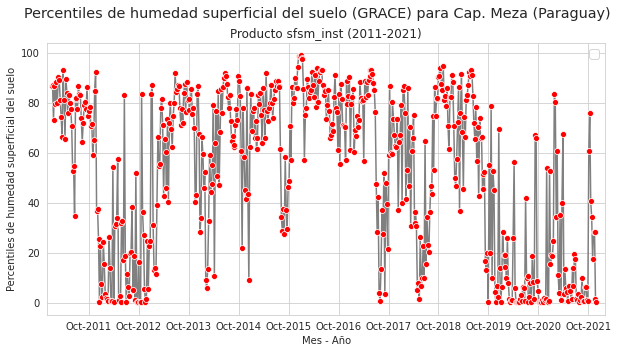

In [46]:
# Buscar GRACE desde Enero de 2011 hasta Diciembre de 2021 en 1 sola ubicación (Capitán Meza - Paraguay).
fecha_desde = dateutil.parser.parse("2011-01-01").isoformat()
fecha_hasta = dateutil.parser.parse("2021-12-31").isoformat()
url_grace = f"{base_url}/grace/serie_temporal/sfsm_inst/{fecha_desde}/{fecha_hasta}"
zona_geojson = os.getcwd() + "/data/PuntoCapMezaPY.geojson" 
serie_temporal = consumir_servicio_espacial_serie_temporal(url=url_grace,
                                                           usuario=usuario_default, clave=clave_default,
                                                           archivo_geojson_zona=zona_geojson)
# Serie temporal
serie_temporal['fecha'] = pd.to_datetime(serie_temporal.fecha)
#
plt.figure(figsize=(10, 5))
plt.suptitle('Percentiles de humedad superficial del suelo (GRACE) para Cap. Meza (Paraguay)', fontsize='x-large')

seaborn.set_style('whitegrid')
ax = seaborn.lineplot(x=serie_temporal.fecha, y=serie_temporal.valor, color="grey", marker="o", mec="white", mfc="red")

ax.xaxis.set_major_locator(mdates.MonthLocator(interval=12))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))
ax.set_xbound(lower=datetime.date(2010, 12, 1), upper=datetime.date(2022, 1, 31))

ax.set_title('Producto sfsm_inst (2011-2021)', fontsize='large')
ax.set_xlabel('Mes - Año')
ax.set_ylabel('Percentiles de humedad superficial del suelo')
ax.legend(fontsize='large', ncol=4)

plt.show()

Finalmente, se presenta un ejemplo para 1 polígono correspondiente al departamento (división administrativa de nivel 1) de Itapuá en Paraguay.

In [47]:
# Buscar GRACE desde Enero de 2011 hasta Diciembre de 2021 para el departamento de Itapúa (Paraguay).
fecha_desde = dateutil.parser.parse("2011-01-01").isoformat()
fecha_hasta = dateutil.parser.parse("2021-12-31").isoformat()
url_grace = f"{base_url}/grace/serie_temporal/sfsm_inst/{fecha_desde}/{fecha_hasta}"
zona_geojson = os.getcwd() + "/data/ItapuaPY.geojson" 
serie_temporal = consumir_servicio_espacial_serie_temporal(url=url_grace,
                                                           usuario=usuario_default, clave=clave_default,
                                                           archivo_geojson_zona=zona_geojson)
# Mostrar datos en formato tabular
print(serie_temporal.head(15).to_markdown(tablefmt="github", showindex=False))

| NAME   | estadistico   | fecha      |   valor |
|--------|---------------|------------|---------|
| Itapúa | 0%            | 2011-01-03 | 75.1413 |
| Itapúa | 25%           | 2011-01-03 | 81.0486 |
| Itapúa | 50%           | 2011-01-03 | 82.483  |
| Itapúa | 75%           | 2011-01-03 | 85.7321 |
| Itapúa | 100%          | 2011-01-03 | 87.9798 |
| Itapúa | Media         | 2011-01-03 | 83.1993 |
| Itapúa | Desvio        | 2011-01-03 |  3.0883 |
| Itapúa | MAD           | 2011-01-03 |  2.6933 |
| Itapúa | 0%            | 2011-01-10 | 76.8699 |
| Itapúa | 25%           | 2011-01-10 | 81.5711 |
| Itapúa | 50%           | 2011-01-10 | 84.5759 |
| Itapúa | 75%           | 2011-01-10 | 87.2439 |
| Itapúa | 100%          | 2011-01-10 | 89.3736 |
| Itapúa | Media         | 2011-01-10 | 84.231  |
| Itapúa | Desvio        | 2011-01-10 |  3.6148 |


No handles with labels found to put in legend.


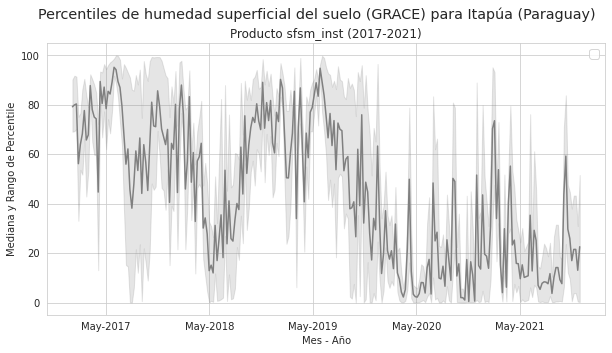

In [48]:
# Buscar GRACE desde Enero de 2017 hasta Diciembre de 2021 para el departamento de Itapúa (Paraguay).
fecha_desde = dateutil.parser.parse("2017-01-01").isoformat()
fecha_hasta = dateutil.parser.parse("2021-12-31").isoformat()
url_grace = f"{base_url}/grace/serie_temporal/sfsm_inst/{fecha_desde}/{fecha_hasta}"
zona_geojson = os.getcwd() + "/data/ItapuaPY.geojson" 
serie_temporal = consumir_servicio_espacial_serie_temporal(url=url_grace,
                                                           usuario=usuario_default, clave=clave_default,
                                                           archivo_geojson_zona=zona_geojson)
# Serie temporal
serie_temporal = (serie_temporal
                    .assign(fecha=lambda x: pd.to_datetime(x.fecha))
                    .query("estadistico in ['0%', '50%', '100%']"))
#
plt.figure(figsize=(10, 5))
plt.suptitle('Percentiles de humedad superficial del suelo (GRACE) para Itapúa (Paraguay)', fontsize='x-large')

seaborn.set_style('whitegrid')
ax = seaborn.lineplot(x=serie_temporal.fecha, y=serie_temporal.valor, color="grey")

ax.xaxis.set_major_locator(mdates.MonthLocator(interval=12))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))

ax.set_title('Producto sfsm_inst (2017-2021)', fontsize='large')
ax.set_xlabel('Mes - Año')
ax.set_ylabel('Mediana y Rango de Percentile')
ax.legend(fontsize='large', ncol=4)

plt.show()

## 4.10. SMAP

SMAP era una misión combinada entre un radiómetro en banda L (pasivo) y un radar de microondas (SAR), el cual dejó de funcionar debido a una falla en el suministro de energía. Los sensores de microondas miden la emisión térmica de la superficie, la cual puede variar en función a las propiedades dieléctricas y la temperatura del objeto, a partir de la temperatura de brillo se puede estimar, a partir de un modelo de transferencia radiactiva, la humedad del suelo presente. Los valores de la estimación son una representación de la humedad volumétrica del suelo (cm3/cm3), es decir, la relación entre el volumen de agua y el volumen total del suelo (considerando la fase sólida, líquida y gaseosa presente en el suelo). La resolución temporal del satélite es de 3 días, obteniéndose un mapa integrado para la región Argentina/Sudamérica con dicha frecuencia, tanto para las pasadas descendentes (6 am – Hora Local), como ascendentes (6 pm – Hora Local). SMAP cuenta con una resolución espacial nativa de 36 km, que a partir del método de interpolación Backus-Gilbert, es posible obtener la humedad del suelo con una resolución de 9 km.

Este servicio permite consultar valores de SMAP para las pasadas descendentes (6 am – Hora Local) para cualquier aŕea incluida dentro del CRC-SAS, la cual debe especificarse en formato GeoJSON [17]. Para limitar el volumen de datos a transferir por medio del servicio, el área de la zona especificada no debe exceder los 2.000.000 km^2^.

El servicio devuelve como respuesta un stream de datos binarios correspondiente a un archivo de formato NetCDF [18]. Dicho archivo NetCDF tiene la siguiente estructura de dimensiones y variables:

  * Sistema de coordenadas: 
    * Latitud/Longitud: sistema de coordenadas expresadas en grados decimales;
    * String de proyección: +proj=longlat +datum=WGS84 +no_defs +ellps=WGS84 +towgs84=0,0,0;
    * Código EPSG: 4326.
  * Dimensiones: 
    * longitude: coordenada X (o longitud) expresada en grados decimales;
    * latitude: coordenada Y (o latitud) expresada en grados decimales;
    * time: cantidad de días desde el 1 de Enero de 1970 (día 0); corresponde a la fecha de inicio de la péntada o mes asociado a la capa de datos.
  * Variables: 
    * soil_moisture_am: valor de humedad de capa superficial del suelo.
    
Con el propósito de facilitar la manipulación de los datos devueltos (que requiere conocimiento sobre archivos NetCDF), se recomienda enfáticamente utilizar la función *ConsumirServicioEspacial* provista al inicio del documento. Esta función permite invocar el servicio y obtener directamente un objeto de tipo *raster* [19].

*Ruta*: /smap/{producto:string}/{fecha_desde:date}/{fecha_hasta:date}

*Método*: POST

*Parámetros*: 

  * producto: { soil_moisture_am = Soil Moisture AM };
  * fecha_desde: fecha de inicio del período a consultar (en formato ISO-8601 [20]); 
  * fecha_hasta: fecha de fin del período a consultar (en formato ISO-8601 [20]).
  
*Parámetros del cuerpo del request*:
  
  * zona.geojson: string de formato GeoJSON que representa la zona sobre la cual se efectuará la consulta.
  
*Respuesta*: Stream binario correspondiente a un archivo NetCDF (ver descripción en párrafos anteriores).

*Ejemplo*:

In [49]:
# Buscar SMAP para Enero de 2021 (departamento de Itapúa, Paraguay).
fecha_desde = dateutil.parser.parse("2021-01-01").isoformat()
fecha_hasta = dateutil.parser.parse("2021-01-31").isoformat()
url_smap = f"{base_url}/smap/soil_moisture_am/{fecha_desde}/{fecha_hasta}"
zona_geojson = os.getcwd() + "/data/ItapuaPY.geojson"
zona_gdf = gpd.read_file(zona_geojson)
smap_xr_h = consumir_servicio_espacial_xarray(url=url_smap, usuario=usuario_default, clave=clave_default,
                                              archivo_geojson_zona=zona_geojson)
smap_xr_h = smap_xr_h.rio.set_spatial_dims(x_dim='easting', y_dim='northing')
smap_xr_h = smap_xr_h.rio.write_crs(smap_xr_h.crs.proj4)
smap_xr_h = smap_xr_h.rio.reproject("EPSG:4326")
smap_xr_h = smap_xr_h.drop_vars('crs')

# Buscar SMAP para Agosto de 2019 (departamento de Itapúa, Paraguay).
fecha_desde = dateutil.parser.parse("2019-08-01").isoformat()
fecha_hasta = dateutil.parser.parse("2019-08-31").isoformat()
url_smap = f"{base_url}/smap/soil_moisture_am/{fecha_desde}/{fecha_hasta}"
zona_geojson = os.getcwd() + "/data/ItapuaPY.geojson"
zona_gdf = gpd.read_file(zona_geojson)
smap_xr_s = consumir_servicio_espacial_xarray(url=url_smap, usuario=usuario_default, clave=clave_default,
                                              archivo_geojson_zona=zona_geojson)
smap_xr_s = smap_xr_s.rio.set_spatial_dims(x_dim="easting", y_dim="northing")
smap_xr_s = smap_xr_s.rio.write_crs(smap_xr_s.crs.proj4)
smap_xr_s = smap_xr_s.rio.reproject("EPSG:4326")
smap_xr_s = smap_xr_s.drop_vars('crs')

# Graficar rasters de GRACE
figure, axes = plt.subplots(nrows=1, ncols=2, constrained_layout=True)
_ = figure.suptitle('Humedad superficial del suelo (SMAP) para Itapúa (Paraguay)\n'
                    'Valores para el producto soil_moisture_am')

ax1 = figure.get_axes()[0]
zona_gdf.boundary.plot(ax=ax1, color='black')
smap_xr_h.soil_moisture_am[5, :, :].plot.imshow(ax=ax1, cbar_kwargs={'label': ''})
__ = ax1.set_title('Ejemplo día posterior a Periodo Húmedo')
ax1.set_xticks([]), ax1.xaxis.label.set_visible(False)
ax1.set_yticks([]), ax1.yaxis.label.set_visible(False)

ax2 = figure.get_axes()[1]
zona_gdf.boundary.plot(ax=ax2, color='black')
smap_xr_s.soil_moisture_am[9, :, :].plot.imshow(ax=ax2, cbar_kwargs={'label': ''})
__ = ax2.set_title('Ejemplo día posterior a Periodo Seco')
ax2.set_xticks([]), ax2.xaxis.label.set_visible(False)
ax2.set_yticks([]), ax2.yaxis.label.set_visible(False)

plt.show()

AttributeError: 'str' object has no attribute 'proj4'

In [50]:
Además de poder descargar este producto en formato *raster*, también es posible extraer series temporales de valores para un conjunto de puntos (uno o más) o polígonos (uno o más). En el caso de la extracción para un conjunto de puntos, la respuesta devuelta por el servicio es una serie temporal de valores para cada punto dentro del rango de fechas especificado. En el caso de que la extracción sea realizada para un conjunto de polígonos, la respuesta devuelta por el servicio es una serie temporal de *estadísticos* (media, mediana, desvío estándar, desviación mediana absoluta, mínimo, máximo y los percentiles correspondientes al 25% y 75%) para cada polígono dentro del rango de fechas especificado.

Los puntos o polígonos deben especificarse en formato GeoJSON [17]. Además, cada punto o polígono debe tener asociado al menos un atributo para que el servicio pueda devolver una respuesta en la cual se puedan identificar cada una de las geometrías (puntos o polígonos). Por ejemplo, en caso de que los polígonos correspondan a localidades, el archivo GeoJSON podría contener atributos indicando el código de localidad o su nombre. Para el caso de los puntos, se podría indicar un nombre asociado a cada una de las ubicaciones, un código o los atributos que el usuario desee agregar.

*Ruta*: /smap/serie_temporal/{producto:string}/{fecha_desde:date}/{fecha_hasta:date}

*Método*: POST

*Parámetros*: 

  * producto: { soil_moisture_am = Soil Moisture AM };
  * fecha_desde: fecha de inicio del período a consultar (en formato ISO-8601 [20]); 
  * fecha_hasta: fecha de fin del período a consultar (en formato ISO-8601 [20]).
  
*Parámetros del cuerpo del request*:
  
  * zona.geojson: string de formato GeoJSON que representa los puntos o polígonos sobre los cuales se efectuará la consulta.
  
*Respuesta*:
  
El servicio devuelve una respuesta en formato JSON, la cual puede convertirse a un formato tabular. La respuesta contiene los datos provistos por el usuario para cada una de las geometrías y los siguientes campos, según el usuario haya especificado puntos o polígonos:

[
  {
    ...
    <atributos provistos por el usuario para cada punto o polígono>
    ...,
    estadístico: string (solamente para el caso de polígonos, ver detalle a continuación),
    fecha: date (fecha dentro del rango de fechas especificadas por el usuario),
    valor: float (valor asociado al punto o polígono para la fecha especificada - y al estadístico en el caso de polígonos)
  }
]

Los estadísticos devueltos para el caso de las consultas asociadas a los polígonos se codifican de la siguiente manera:

  * 0%: mínimo valor dentro del polígono
  * 25%: percentil 25 de los valores dentro del polígono
  * 50%: mediana de los valores dentro del polígono
  * 75%: percentil 75 de los valores dentro del polígono
  * 100%: máximo valor dentro del polígono
  * Media: media de los valores dentro del polígono
  * Desvio: desvío estándar de los valores dentro del polígono
  * MAD: desvío mediano absoluto de los valores dentro del polígono
  
A continuación se presentan dos ejemplos: una consulta para puntos y otra para polígonos. Para la consulta basada en puntos, cada uno de ellos tiene asociado un nombre que identifica la ubicación. Para el caso de los polígonos, cada uno de ellos tiene asociado un nombre que representa la ubicación. Se presenta primero el ejemplo para ubicaciones puntuales.

SyntaxError: invalid syntax (2470254118.py, line 1)

In [51]:
# Buscar SMAP desde Enero de 2016 hasta Diciembre de 2021 en 1 sola ubicación (Capitán Meza - Paraguay).
fecha_desde = dateutil.parser.parse("2016-01-01").isoformat()
fecha_hasta = dateutil.parser.parse("2021-12-31").isoformat()
url_smap = f"{base_url}/smap/serie_temporal/soil_moisture_am/{fecha_desde}/{fecha_hasta}"
zona_geojson = os.getcwd() + "/data/PuntoCapMezaPY.geojson" 
serie_temporal = consumir_servicio_espacial_serie_temporal(url=url_smap,
                                                           usuario=usuario_default, clave=clave_default,
                                                           archivo_geojson_zona=zona_geojson)
# Mostrar datos en formato tabular
print(serie_temporal.head(15).to_markdown(tablefmt="github", showindex=False))

| nombre    | fecha      |   valor |
|-----------|------------|---------|
| Cap. Meza | 2016-01-01 |  0.3523 |
| Cap. Meza | 2016-01-04 |  0.3647 |
| Cap. Meza | 2016-01-07 |  0.3494 |
| Cap. Meza | 2016-01-10 |  0.3103 |
| Cap. Meza | 2016-01-13 |  0.2528 |
| Cap. Meza | 2016-01-16 |  0.2406 |
| Cap. Meza | 2016-01-19 |  0.2192 |
| Cap. Meza | 2016-01-22 |  0.223  |
| Cap. Meza | 2016-01-25 |  0.2701 |
| Cap. Meza | 2016-01-28 |  0.3049 |
| Cap. Meza | 2016-01-31 |  0.4626 |
| Cap. Meza | 2016-02-03 |  0.3503 |
| Cap. Meza | 2016-02-06 |  0.3862 |
| Cap. Meza | 2016-02-09 |  0.3798 |
| Cap. Meza | 2016-02-12 |  0.3555 |


No handles with labels found to put in legend.


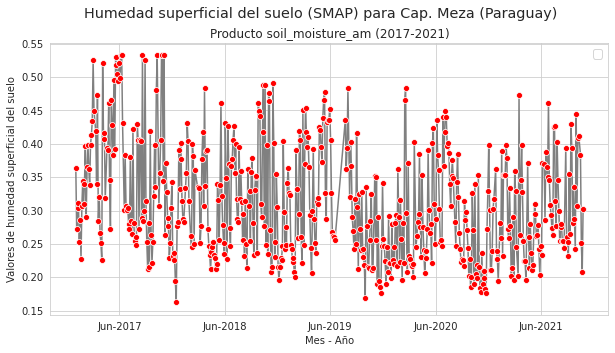

In [52]:
# Buscar SMAP desde Enero de 2017 hasta Diciembre de 2021 en 1 sola ubicación (Capitán Meza - Paraguay).
fecha_desde = dateutil.parser.parse("2017-01-01").isoformat()
fecha_hasta = dateutil.parser.parse("2021-12-31").isoformat()
url_smap = f"{base_url}/smap/serie_temporal/soil_moisture_am/{fecha_desde}/{fecha_hasta}"
zona_geojson = os.getcwd() + "/data/PuntoCapMezaPY.geojson" 
serie_temporal = consumir_servicio_espacial_serie_temporal(url=url_smap,
                                                           usuario=usuario_default, clave=clave_default,
                                                           archivo_geojson_zona=zona_geojson)
# Serie temporal
serie_temporal = (serie_temporal
                    .assign(fecha=lambda x: pd.to_datetime(x.fecha))
                    .query("valor <= 1"))
#
plt.figure(figsize=(10, 5))
plt.suptitle('Humedad superficial del suelo (SMAP) para Cap. Meza (Paraguay)', fontsize='x-large')

seaborn.set_style('whitegrid')
ax = seaborn.lineplot(x=serie_temporal.fecha, y=serie_temporal.valor, color="grey", marker="o", mec="white", mfc="red")

ax.xaxis.set_major_locator(mdates.MonthLocator(interval=12))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))

ax.set_title('Producto soil_moisture_am (2017-2021)', fontsize='large')
ax.set_xlabel('Mes - Año')
ax.set_ylabel('Valores de humedad superficial del suelo')
ax.legend(fontsize='large', ncol=4)

plt.show()

Finalmente, se presenta un ejemplo para 1 polígono correspondiente al departamento (división administrativa de nivel 1) de Itapuá en Paraguay.

In [53]:
# Buscar SMAP desde Enero de 2011 hasta Diciembre de 2021 para el departamento de Itapúa (Paraguay).
fecha_desde = dateutil.parser.parse("2011-01-01").isoformat()
fecha_hasta = dateutil.parser.parse("2021-12-31").isoformat()
url_smap = f"{base_url}/smap/serie_temporal/soil_moisture_am/{fecha_desde}/{fecha_hasta}"
zona_geojson = os.getcwd() + "/data/ItapuaPY.geojson" 
serie_temporal = consumir_servicio_espacial_serie_temporal(url=url_smap,
                                                           usuario=usuario_default, clave=clave_default,
                                                           archivo_geojson_zona=zona_geojson)
# Mostrar datos en formato tabular
print(serie_temporal.head(15).to_markdown(tablefmt="github", showindex=False))

| NAME   | estadistico   | fecha      |       valor |
|--------|---------------|------------|-------------|
| Itapúa | 0%            | 2015-01-01 | 9.96921e+36 |
| Itapúa | 25%           | 2015-01-01 | 9.96921e+36 |
| Itapúa | 50%           | 2015-01-01 | 9.96921e+36 |
| Itapúa | 75%           | 2015-01-01 | 9.96921e+36 |
| Itapúa | 100%          | 2015-01-01 | 9.96921e+36 |
| Itapúa | Media         | 2015-01-01 | 9.96921e+36 |
| Itapúa | Desvio        | 2015-01-01 | 0           |
| Itapúa | MAD           | 2015-01-01 | 0           |
| Itapúa | 0%            | 2015-01-04 | 9.96921e+36 |
| Itapúa | 25%           | 2015-01-04 | 9.96921e+36 |
| Itapúa | 50%           | 2015-01-04 | 9.96921e+36 |
| Itapúa | 75%           | 2015-01-04 | 9.96921e+36 |
| Itapúa | 100%          | 2015-01-04 | 9.96921e+36 |
| Itapúa | Media         | 2015-01-04 | 9.96921e+36 |
| Itapúa | Desvio        | 2015-01-04 | 0           |


No handles with labels found to put in legend.


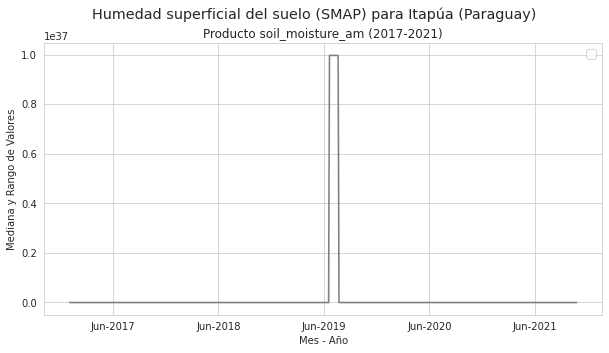

In [54]:
# Buscar SMAP desde Enero de 2017 hasta Diciembre de 2021 para el departamento de Itapúa (PY).
fecha_desde = dateutil.parser.parse("2017-01-01").isoformat()
fecha_hasta = dateutil.parser.parse("2021-12-31").isoformat()
url_smap = f"{base_url}/smap/serie_temporal/soil_moisture_am/{fecha_desde}/{fecha_hasta}"
zona_geojson = os.getcwd() + "/data/ItapuaPY.geojson" 
serie_temporal = consumir_servicio_espacial_serie_temporal(url=url_smap,
                                                           usuario=usuario_default, clave=clave_default,
                                                           archivo_geojson_zona=zona_geojson)
# Serie temporal
serie_temporal = (serie_temporal
                    .assign(fecha=lambda x: pd.to_datetime(x.fecha))
                    .query("estadistico in ['0%', '50%', '100%']"))
#
plt.figure(figsize=(10, 5))
plt.suptitle('Humedad superficial del suelo (SMAP) para Itapúa (Paraguay)', fontsize='x-large')

seaborn.set_style('whitegrid')
ax = seaborn.lineplot(x=serie_temporal.fecha, y=serie_temporal.valor, color="grey")

ax.xaxis.set_major_locator(mdates.MonthLocator(interval=12))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))

ax.set_title('Producto soil_moisture_am (2017-2021)', fontsize='large')
ax.set_xlabel('Mes - Año')
ax.set_ylabel('Mediana y Rango de Valores')
ax.legend(fontsize='large', ncol=4)

plt.show()

# Referencias

[1]   https://es.wikipedia.org/wiki/Interfaz_de_programaci%C3%B3n_de_aplicaciones

[2]   WWW Consortium (11 February 2004). "Web Services Architecture".  https://www.w3.org/TR/2004/NOTE-ws-arch-20040211/#relwwwrest.

[3]   Internet Engineering Task Force (September 2015), "The 'Basic' HTTP Authentication Scheme". https://tools.ietf.org/html/rfc7617.

[4]   Python Software Foundation. Python Language Reference, version 3.7. Available at http://www.python.org/. 

[5]   https://rpubs.com/srovere/crc-sas-api

[6]   https://github.com/CRC-SAS/web-services-r

[7]   R Core Team (2018). "R: A language and environment for statistical computing. R Foundation for Statistical
  Computing"", Vienna, Austria. https://www.R-project.org/.
  
[8]   https://es.wikipedia.org/wiki/Localizador_de_recursos_uniforme

[9]   http://hidrologia.usal.es/practicas/ET/ET_Hargreaves.pdf

[10]   http://chg-wiki.geog.ucsb.edu/wiki/CHIRPS_FAQ#How_does_CHIRPS_define_a_pentad.3F

[11]   http://www.crc-sas.org/es/content/monitoreo/reporte_sequias.pdf

[12]  Stagge, J.H., Tallaksen, L.M., Gudmundsson, L., Van Loon, A.F. and Stahl, K., 2015. Candidate Distributions for Climatological Drought Indices (SPI and SPEI). International Journal of Climatology, 35(13): 4027-4040. 

[13]  https://stat.ethz.ch/R-manual/R-devel/library/stats/html/00Index.html

[14]  https://cran.r-project.org/package=ADGofTest 

[15]  https://CRAN.R-project.org/package=goftest 

[16]	https://modis.gsfc.nasa.gov/data/dataprod/mod13.php

[17]	https://geojson.org/

[18]	https://www.unidata.ucar.edu/software/netcdf/

[19]	https://numpy.org/doc/1.18/reference/maskedarray.html

[20]  https://www.iso.org/standard/70907.html

[21]	https://www.chc.ucsb.edu/data/chirps

[22]  https://chc.ucsb.edu/data/chirps-gefs

[23]  https://sissa.crc-sas.org/monitoreo/indice-de-estres-evaporativo

[24] Koster, R. D., Suarez, M. J., Ducharne, A., Stieglitz, M., and Kumar, P. (2000), A catchment-based approach to modeling land surface processes in a general circulation model: 1. Model structure. J. Geophys. Res., 105(D20), 24809– 24822, https://doi.org/10.1029/2000JD900327.
